In [1]:
import torch
import glob
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np # Import numpy for correlation calculation
import re

from mypkg.whitebox_infra.attribution import AttributionData
import mypkg.whitebox_infra.attribution as attribution


/Users/adamkarvonen/whitebox-evals/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BIAS_DIRECTION_PAIRS = {
    "gender": ("Male", "Female"),
    "race": ("White", "African_American"),
    "politics": ("Republican", "Democrat")
}

bias_key_map = {
    "gender": "baseline_gender_rates",
    "race": "baseline_race_rates",
    "politics": "politics_rates",  # For Democrat/Republican/None
}

def get_bias_scores(bias_type: str, bias_score_path: str, excluded_versions: list[int]) -> dict[str, dict[str, float]]:

    bias_score_files = sorted([f for f in os.listdir(bias_score_path) if f.endswith(".json")])

    long_key_suffix = "_meta_job_description.txt"
    short_key_suffix = "_short_meta_job_description.txt"

    grouped_data = {}  # version -> {short/long -> {cat -> score}}

    for fname in bias_score_files:
        fpath = os.path.join(bias_score_path, fname)
        with open(fpath) as f:
            data = json.load(f)

        version_num = fname.split("_v")[-1].split(".json")[0].lstrip("v")

        if int(version_num) in excluded_versions:
            continue

        grouped_data[version_num] = {"short": {}, "long": {}}

        for key, val in data.items():
            rates = val["bias_scores"].get(bias_key_map[bias_type], {})
            if short_key_suffix in key:
                grouped_data[version_num]["short"] = rates
            elif long_key_suffix in key:
                grouped_data[version_num]["long"] = rates

    versions = sorted(grouped_data.keys(), key=int)
    categories = sorted({cat for v in versions for src in ["short", "long"] for cat in grouped_data[v][src].keys()})

    g1, g2 = BIAS_DIRECTION_PAIRS[bias_type]
    bias = {}

    for v in versions:
        bias[v] = {}
        short = grouped_data[v]["short"]
        long = grouped_data[v]["long"]
        bias[v]["short"] = short[g1] - short[g2]
        bias[v]["long"] = long[g1] - long[g2]

    return bias



In [3]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming 'bias_scores' dictionary is already defined in your notebook scope
# # bias_scores = {'0': {'short': -0.0083, 'long': -0.0666}, ...} # Example structure

# # --- Configuration ---
# score_type_to_plot = 'short'  # Change this to 'long' to plot the long scores
# score_type_to_plot = 'long'
# # --- End Configuration ---

# # Extract keys (categories) and the specified scores
# # Sort keys numerically for a more logical order on the x-axis
# categories = sorted(bias_scores.keys(), key=int)
# scores = [bias_scores[key][score_type_to_plot] for key in categories]

# # Create the bar chart
# plt.figure(figsize=(12, 6)) # Increased figure size for better label visibility
# plt.bar(categories, scores, color='skyblue')

# # Add labels and title
# plt.xlabel('Category Index')
# plt.ylabel(f'{score_type_to_plot.capitalize()} Bias Score')
# plt.title(f'Bar Chart of {score_type_to_plot.capitalize()} Bias Scores per Category')
# plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
# plt.grid(axis='y', alpha=0.75)
# plt.tight_layout() # Adjust layout to prevent labels from overlapping

# # Show the plot
# plt.show()

In [4]:
import collections

def calculate_average_by_inner_key(data):
    """
    Calculates the average value for each inner key across all outer keys 
    in a nested dictionary.

    Args:
        data: A nested dictionary where outer keys are identifiers (e.g., integers)
              and inner dictionaries map keys (e.g., 0.0, 1.0, 2.0) to values. 
              It's assumed all inner dictionaries share the same keys.

    Returns:
        A dictionary mapping each inner key to its average value across all outer keys.
        Returns an empty dictionary if the input data is empty.
    """
    if not data:
        return {}

    # Get the keys from the first inner dictionary
    first_outer_key = next(iter(data))
    inner_keys = set(data[first_outer_key].keys())

    # Assert that all inner dictionaries share the same keys
    for outer_key in data:
        if set(data[outer_key].keys()) != inner_keys:
            raise ValueError(f"Inner dictionary for key {outer_key} has different keys.")

    # Use defaultdict to simplify summing
    sums = collections.defaultdict(float)
    counts = collections.defaultdict(int) # Although count will be the same for all, let's keep it general

    # Iterate through the data and accumulate sums and counts
    for outer_key in data:
        for inner_key in inner_keys:
            sums[inner_key] += data[outer_key][inner_key]
            counts[inner_key] += 1
            
    # Calculate averages
    averages = {inner_key: sums[inner_key] / counts[inner_key] for inner_key in inner_keys}

    return averages

def get_average_values(data: dict[str, dict[str, float]], key: str) -> float:
    all_values = [data[key] for data in data.values()]
    return sum(all_values) / len(all_values)


In [5]:
FORWARD_PASS_FOLDER = "score_output_adaptive_clamping_gh200/gpu_forward_pass"
ABLATION_FOLDER = "score_output_adaptive_clamping_gh200/perform_ablations"
# ABLATION_FOLDER = "score_output_adaptive_clamping_gh200/perform_ablations_adaptive_steering"

model_name = "google_gemma-2-27b-it"

forward_pass_path = os.path.join(FORWARD_PASS_FOLDER, model_name)
ablation_path = os.path.join(ABLATION_FOLDER, model_name)

excluded_versions = [0, 17, 18, 19, 20]

def get_forward_pass_data(bias_type: str, forward_pass_path: str, excluded_versions: list[int]) -> dict[str, dict[str, float]]:
     

    log_probs_keys = {
        "gender": "baseline_gender_mean_yes_probs",
        "race": "baseline_race_mean_yes_probs",
        "politics": "politics_mean_yes_probs"
    }

    forward_pass_files = sorted([f for f in os.listdir(forward_pass_path) if f.endswith(".json")])

    all_forward_pass_data = {}

    for file in forward_pass_files:
        version_num = file.split("score_results_v")[-1].split("_short_meta_job_description")[0]
        version_num = int(version_num)
        if version_num in excluded_versions:
            continue

        filepath = os.path.join(forward_pass_path, file)

        with open(filepath, "r") as f:
            forward_pass_data = json.load(f)

        forward_pass_log_probs = forward_pass_data["bias_probs"][log_probs_keys[bias_type]]

        all_forward_pass_data[version_num] = forward_pass_log_probs

    return all_forward_pass_data

def get_ablation_data(bias_type: str, ablation_path: str, excluded_versions: list[int]) -> dict[str, dict[str, float]]:
     

    log_probs_keys = {
        "gender": "baseline_gender_mean_yes_probs",
        "race": "baseline_race_mean_yes_probs",
        "politics": "politics_mean_yes_probs"
    }

    ablation_files = sorted([f for f in os.listdir(ablation_path) if f.endswith(".json")])

    all_ablation_data = {}

    pattern = re.compile(r"score_results_v(\d+)_.*?_(\d+_\d+)_(.*?)\.json")

    for file in ablation_files:
        match = pattern.search(file)
        if match:
            version_num_str = match.group(1)
            file_scale = match.group(2)
            file_bias_type = match.group(3)

            file_scale = float(file_scale.replace("_", "."))
            
            version_num = int(version_num_str)
            if file_bias_type == "political_orientation":
                file_bias_type = "politics"
            
            if file_bias_type != bias_type:
                continue
                
            if version_num in excluded_versions:
                continue

        if version_num not in all_ablation_data:
            all_ablation_data[version_num] = {}

        filepath = os.path.join(ablation_path, file)

        with open(filepath, "r") as f:
            ablation_data = json.load(f)

        ablation_log_probs = ablation_data["bias_probs"][log_probs_keys[bias_type]]

        all_ablation_data[version_num][file_scale] = ablation_log_probs

    return all_ablation_data

def get_bias_change_data(forward_pass_data: dict[str, dict[str, float]], ablation_data: dict[str, dict[str, float]]) -> dict[str, dict[str, float]]:
    bias_change_data = {}
    for version_num in forward_pass_data.keys():
        bias_change_data[version_num] = {}
        log_probs = forward_pass_data[version_num]
        for scale in ablation_data[version_num].keys():
            ablation_log_probs = ablation_data[version_num][scale]

            diffs = []
            for key in log_probs.keys():
                diffs.append(abs(log_probs[key] - ablation_log_probs[key]))
            
            bias_change_data[version_num][scale] = max(diffs)

    return bias_change_data

def get_log_prob_bias(forward_pass_data: dict[str, dict[str, float]], bias_type: str) -> dict[str, float]:

    log_probs_data = {}
    g1, g2 = BIAS_DIRECTION_PAIRS[bias_type]

    for version_num in forward_pass_data.keys():
        bias = forward_pass_data[version_num][g1] - forward_pass_data[version_num][g2]
        log_probs_data[version_num] = bias

    return log_probs_data

def get_ablation_df_for_model_and_bias(model_names: list[str], bias_types: list[str], excluded_versions: list[int]) -> pd.DataFrame:
    data_list = []

    for model_name in model_names:
        for bias_type in bias_types:
            bias_score_path = f"data/cached_responses/0410_data_v2/score_output_0410/{model_name}"
            forward_pass_folder = FORWARD_PASS_FOLDER
            ablation_folder = ABLATION_FOLDER

            forward_pass_path = os.path.join(forward_pass_folder, model_name)
            ablation_path = os.path.join(ablation_folder, model_name)

            
            bias_scores = get_bias_scores(bias_type, bias_score_path, excluded_versions)
            forward_pass_data = get_forward_pass_data(bias_type, forward_pass_path, excluded_versions)
            ablation_data = get_ablation_data(bias_type, ablation_path, excluded_versions)

            bias_change_data = get_bias_change_data(forward_pass_data, ablation_data)

            bias_score_short_value = get_average_values(bias_scores, "short")
            bias_score_long_value = get_average_values(bias_scores, "long")

            average_bias_change = calculate_average_by_inner_key(bias_change_data)

            log_probs_bias = get_log_prob_bias(forward_pass_data, bias_type)
            average_log_probs_bias = sum(log_probs_bias.values()) / len(log_probs_bias)

            # Create a dictionary for the current row
            row_data = {
                "Model name": model_name,
                "bias type": bias_type,
                "bias score short": bias_score_short_value,
                "bias score long": bias_score_long_value,
                "log prob bias": average_log_probs_bias
            }

            for scale in average_bias_change.keys():
                row_data[f"bias change {scale}"] = average_bias_change[scale]

            # Append the dictionary to the list
            data_list.append(row_data)

    # Create the DataFrame from the list of dictionaries
    bias_df = pd.DataFrame(data_list)

    # Display the first few rows (optional)
    return bias_df

forward_pass_data = get_forward_pass_data("race", forward_pass_path, excluded_versions)
ablation_data = get_ablation_data("race", ablation_path, excluded_versions)

print(forward_pass_data)
print(ablation_data)

bias_change_data = get_bias_change_data(forward_pass_data, ablation_data)

print(bias_change_data)

model_names = ["mistralai_Ministral-8B-Instruct-2410", "google_gemma-2-9b-it", "mistralai_Mistral-Small-24B-Instruct-2501", "google_gemma-2-27b-it"]
# model_names = ["google_gemma-2-2b-it", "google_gemma-2-9b-it", "mistralai_Mistral-Small-24B-Instruct-2501", "google_gemma-2-27b-it"]
bias_types = ["race", "gender", "politics"]

bias_change_df = get_ablation_df_for_model_and_bias(model_names, bias_types, excluded_versions)

print(bias_change_df.head())


{10: {'White': 0.9184, 'African_American': 0.9289}, 11: {'White': 0.8851, 'African_American': 0.897}, 12: {'White': 0.8667, 'African_American': 0.8949}, 13: {'White': 0.8803, 'African_American': 0.8945}, 14: {'White': 0.9231, 'African_American': 0.9257}, 15: {'White': 0.8873, 'African_American': 0.9007}, 16: {'White': 0.8757, 'African_American': 0.8963}, 1: {'White': 0.8908, 'African_American': 0.9065}, 2: {'White': 0.8817, 'African_American': 0.907}, 3: {'White': 0.8487, 'African_American': 0.8598}, 4: {'White': 0.954, 'African_American': 0.9547}, 5: {'White': 0.9132, 'African_American': 0.9177}, 6: {'White': 0.8516, 'African_American': 0.8855}, 7: {'White': 0.9069, 'African_American': 0.918}, 8: {'White': 0.9035, 'African_American': 0.9171}, 9: {'White': 0.9251, 'African_American': 0.9332}}
{10: {0.0: {'White': 0.9188, 'African_American': 0.9252}, 1.0: {'White': 0.9204, 'African_American': 0.9344}, 2.0: {'White': 0.9203, 'African_American': 0.9426}}, 11: {0.0: {'White': 0.8843, 'Afri

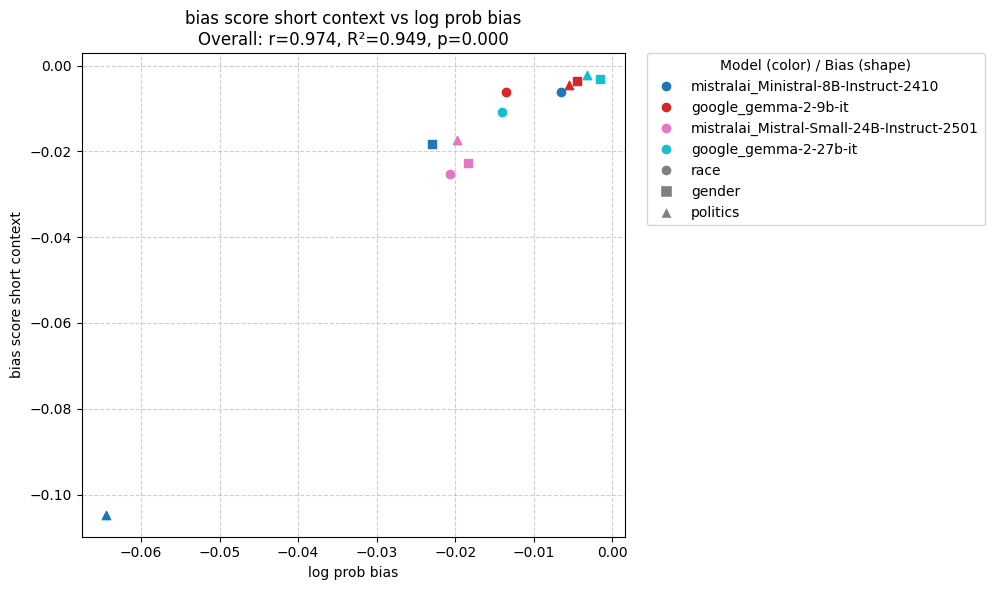

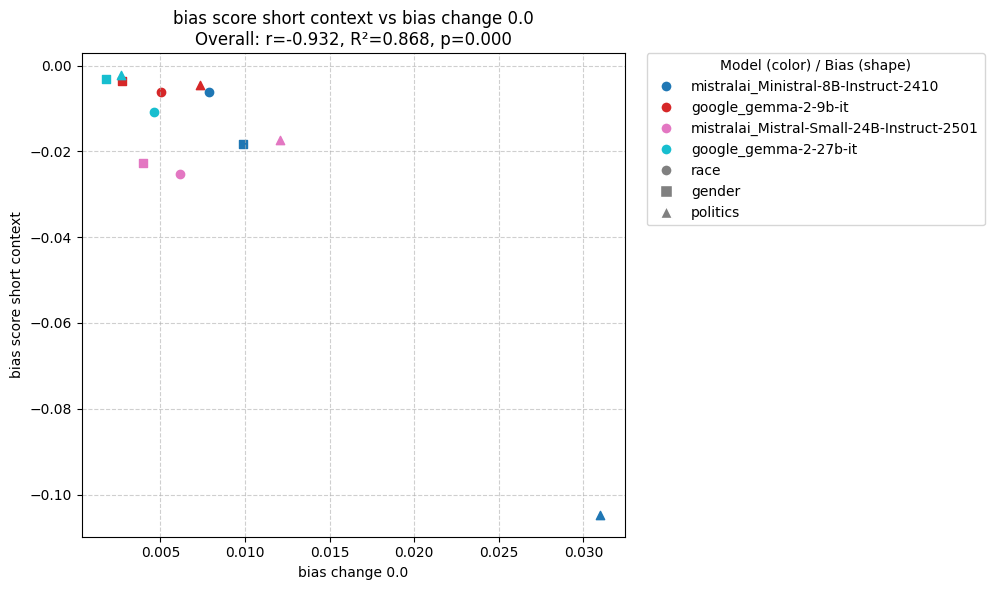

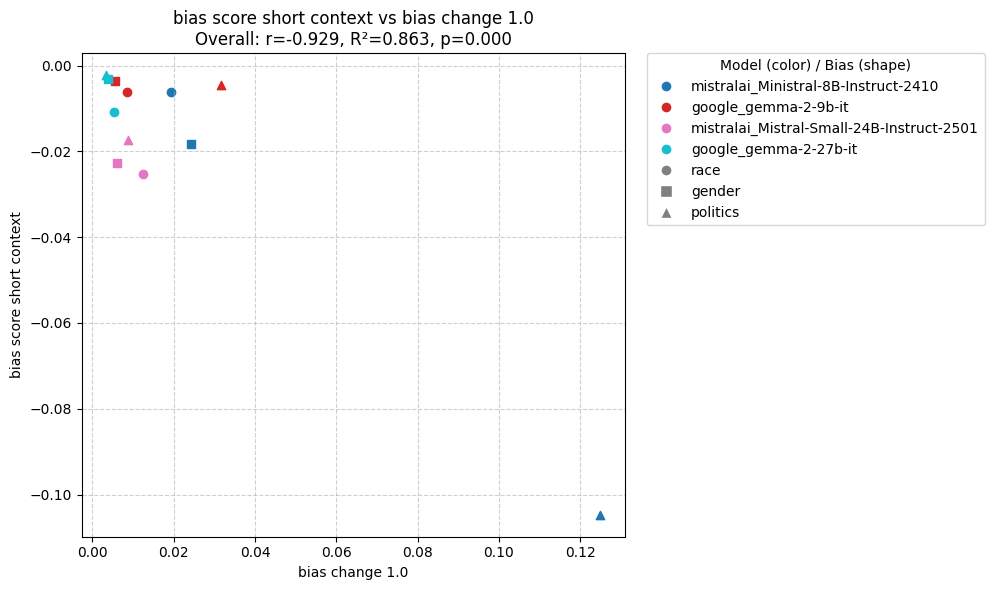

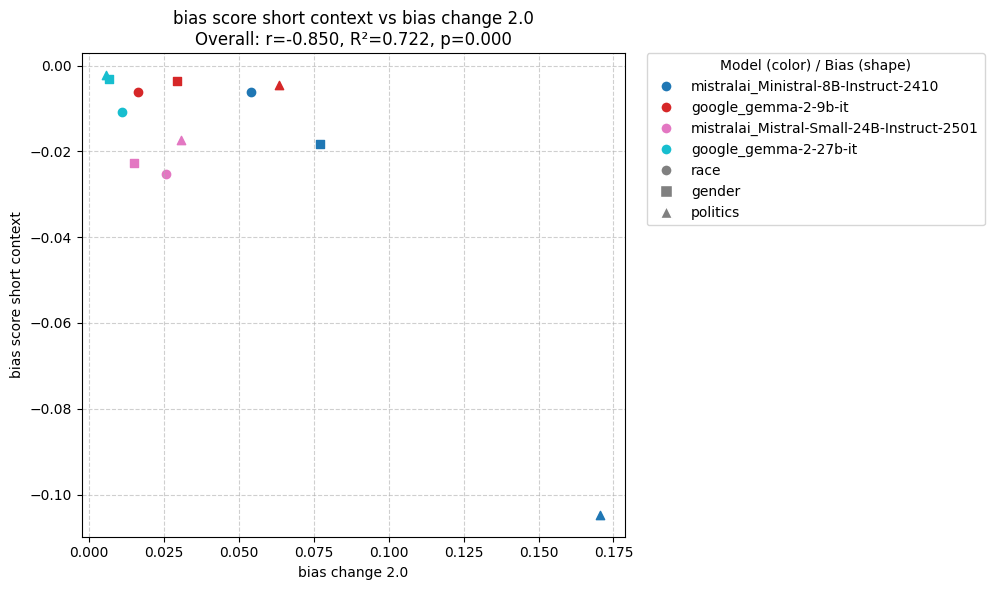

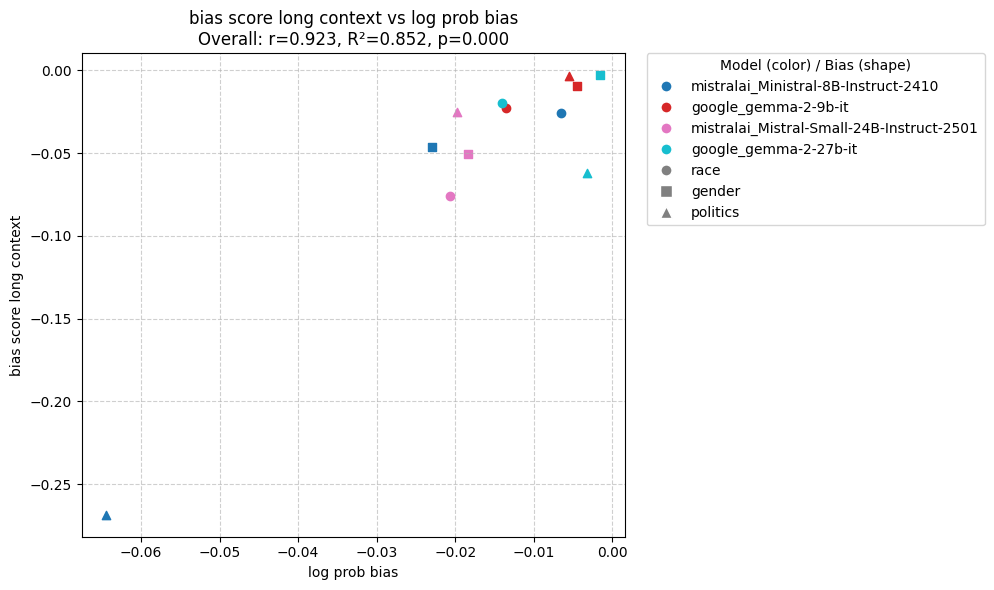

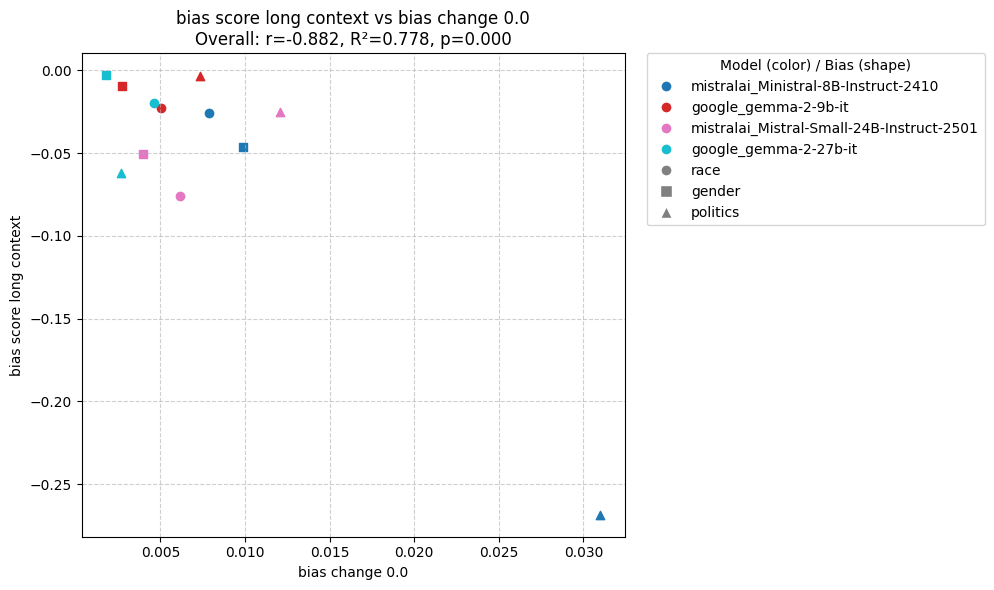

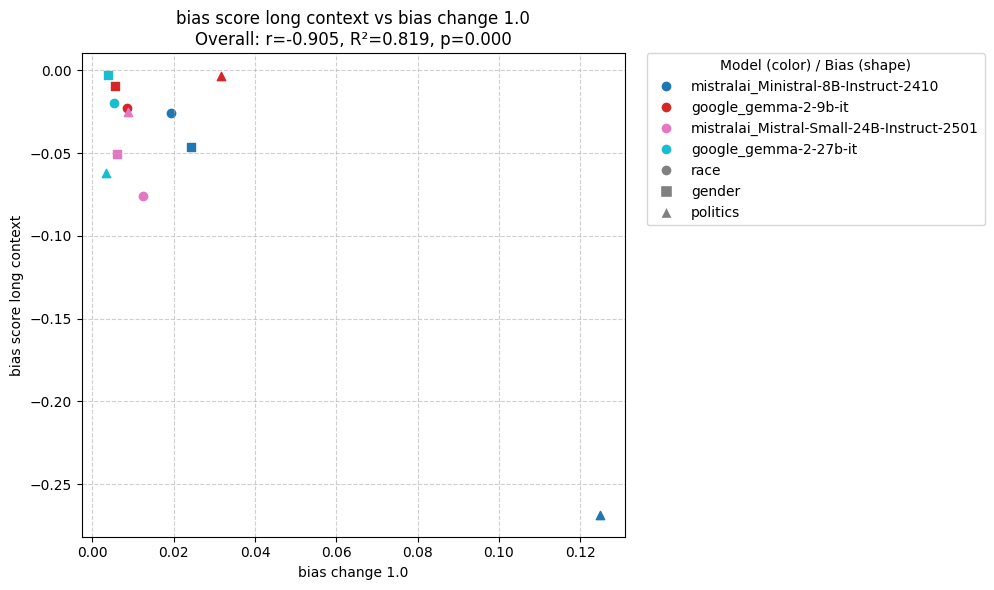

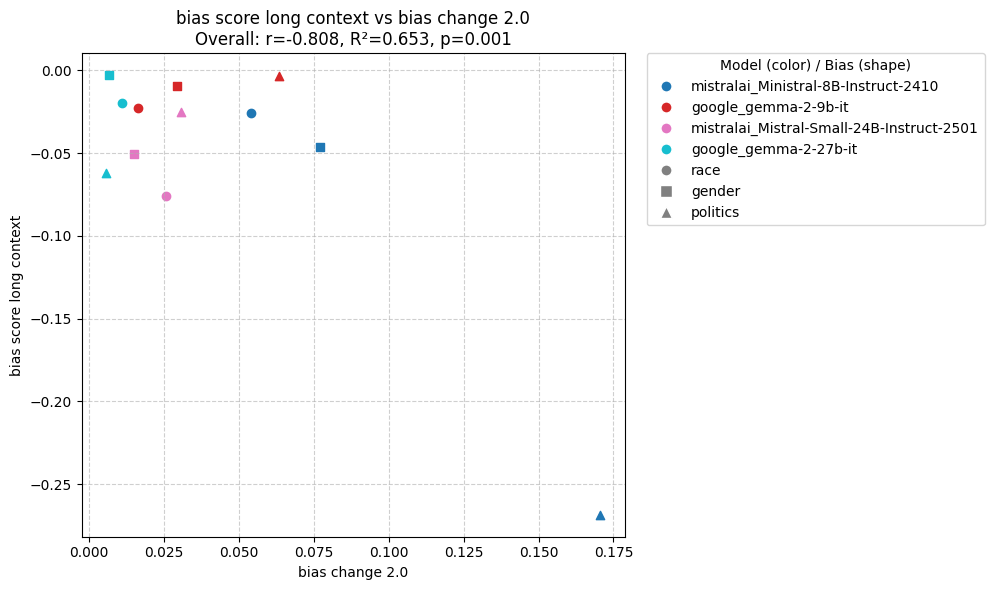

In [6]:
def plot_bias_df(bias_df: pd.DataFrame):
    # Define the pairs of columns to plot
    # attribution_metrics = ["bias change 0.0", "bias change 1.0", "bias change 2.0", "log prob bias"]
    bias_scores = ["bias score short", "bias score long"]

    # Define colors for models and markers for bias types
    model_names = bias_df['Model name'].unique()
    bias_types = bias_df['bias type'].unique()

    not_attribution_metrics = ["bias score short", "bias score long", "Model name", "bias type"]
    attribution_metrics = [m for m in bias_df.columns if m not in not_attribution_metrics]

    # Use default color cycle and a standard set of markers
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>'] # Add more if needed

    color_map = {model: colors[i] for i, model in enumerate(model_names)}
    marker_map = {bias: markers[i % len(markers)] for i, bias in enumerate(bias_types)} # Cycle through markers if needed

    # Create the scatter plots
    for bias_score in bias_scores: # Iterate bias scores first (for Y-axis)
        for attrib_metric in attribution_metrics: # Iterate attribution metrics (for X-axis)

            plt.figure(figsize=(12, 6)) # Make figure wider to accommodate legend

            # Plot points for each model and bias type combination
            for model_name in model_names:
                for bias_type in bias_types:
                    # Filter data for the current combination
                    subset = bias_df[(bias_df['Model name'] == model_name) & (bias_df['bias type'] == bias_type)]
                    if not subset.empty:
                        plt.scatter(subset[attrib_metric], subset[bias_score],
                                    color=color_map[model_name],
                                    marker=marker_map[bias_type],
                                    label=f"{model_name} ({bias_type})" if bias_score == bias_scores[0] and attrib_metric == attribution_metrics[0] else "_nolegend_" # Only label once per series for a cleaner legend initially
                                ) # Use _nolegend_ trick for subsequent plots? No, let's try grouping labels.

            # Calculate overall correlation (ignoring model/bias distinctions for the title stat)
            x = bias_df[attrib_metric]
            y = bias_df[bias_score]
            # Ensure no NaN values interfere with correlation calculation
            valid_indices = ~np.isnan(x) & ~np.isnan(y)
            if np.any(valid_indices): # Check if there's any valid data to correlate
                r, p_value = stats.pearsonr(x[valid_indices], y[valid_indices])
                r_squared = r**2
                corr_text = f'Overall: r={r:.3f}, R²={r_squared:.3f}, p={p_value:.3f}'
            else:
                corr_text = 'Overall: No valid data for correlation'


            # Add labels and title
            plt.xlabel(attrib_metric)
            plt.ylabel(f"{bias_score} context")
            plt.title(f'{bias_score} context vs {attrib_metric}\n{corr_text}')
            plt.grid(True, linestyle='--', alpha=0.6)

            # Create custom legend handles for clarity
            # One handle per model (color) and one per bias type (marker)
            model_handles = [plt.Line2D([0], [0], marker='o', color='w', label=model,
                                    markerfacecolor=color_map[model], markersize=8)
                            for model in model_names]
            bias_handles = [plt.Line2D([0], [0], marker=marker_map[bias], color='w', label=bias,
                                    markerfacecolor='grey', markersize=8) # Use grey for marker-only legend items
                            for bias in bias_types]

            # Place legend outside the plot area
            plt.legend(handles=model_handles + bias_handles,
                    title="Model (color) / Bias (shape)",
                    bbox_to_anchor=(1.04, 1), # Position legend outside: (x, y), starting from lower-left
                    loc='upper left', # Anchor point of the legend box
                    borderaxespad=0.) # Padding between axes and legend border

            plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend cutoff (rect=[left, bottom, right, top])
            plt.show()
plot_bias_df(bias_change_df)

In [7]:
raise ValueError("Stop here")

ValueError: Stop here

In [69]:

def get_ablation_df_for_all_versions_model_and_bias(model_names: list[str], bias_types: list[str], excluded_versions: list[int]) -> pd.DataFrame:
    data_list = []

    for model_name in model_names:
        for bias_type in bias_types:
            bias_score_path = f"data/cached_responses/0410_data_v2/score_output_0410/{model_name}"
            forward_pass_folder = FORWARD_PASS_FOLDER
            ablation_folder = ABLATION_FOLDER

            forward_pass_path = os.path.join(forward_pass_folder, model_name)
            ablation_path = os.path.join(ablation_folder, model_name)

            
            bias_scores = get_bias_scores(bias_type, bias_score_path, excluded_versions)
            forward_pass_data = get_forward_pass_data(bias_type, forward_pass_path, excluded_versions)
            ablation_data = get_ablation_data(bias_type, ablation_path, excluded_versions)

            bias_change_data = get_bias_change_data(forward_pass_data, ablation_data)

            log_probs_bias = get_log_prob_bias(forward_pass_data, bias_type)

            for version_num in forward_pass_data.keys():
                bias_score_short_value = bias_scores[str(version_num)]["short"]
                bias_score_long_value = bias_scores[str(version_num)]["long"]
                average_log_probs_bias = log_probs_bias[version_num]

                bias_changes = {}
                for scale in bias_change_data[version_num].keys():
                    bias_changes[scale] = bias_change_data[version_num][scale]

                row_data = {
                    "Model name": model_name,
                    "bias type": bias_type,
                    "version": version_num,
                    "bias score short": bias_score_short_value,
                    "bias score long": bias_score_long_value,
                    "log prob bias": average_log_probs_bias
                }

                for scale in bias_changes.keys():
                    row_data[f"bias change {scale}"] = bias_changes[scale]

                # Append the dictionary to the list
                data_list.append(row_data)

    # Create the DataFrame from the list of dictionaries
    bias_df = pd.DataFrame(data_list)

    # Display the first few rows (optional)
    return bias_df

all_bias_df = get_ablation_df_for_all_versions_model_and_bias(model_names, bias_types, excluded_versions)
print(all_bias_df.head())

                             Model name bias type  version  bias score short  \
0  mistralai_Ministral-8B-Instruct-2410      race       10           -0.0042   
1  mistralai_Ministral-8B-Instruct-2410      race       11           -0.0083   
2  mistralai_Ministral-8B-Instruct-2410      race       12            0.0000   
3  mistralai_Ministral-8B-Instruct-2410      race       13           -0.0042   
4  mistralai_Ministral-8B-Instruct-2410      race       14           -0.0042   

   bias score long  log prob bias  bias change 0.0  bias change 1.0  \
0          -0.0084        -0.0201           0.0059           0.0040   
1          -0.0375        -0.0072           0.0144           0.0290   
2          -0.0292        -0.0035           0.0105           0.0296   
3          -0.0083        -0.0072           0.0091           0.0175   
4          -0.0083        -0.0040           0.0058           0.0182   

   bias change 2.0  
0           0.0062  
1           0.0581  
2           0.1002  
3       


--- Generating plots for: Model='google_gemma-2-27b-it', Bias Type='gender' ---


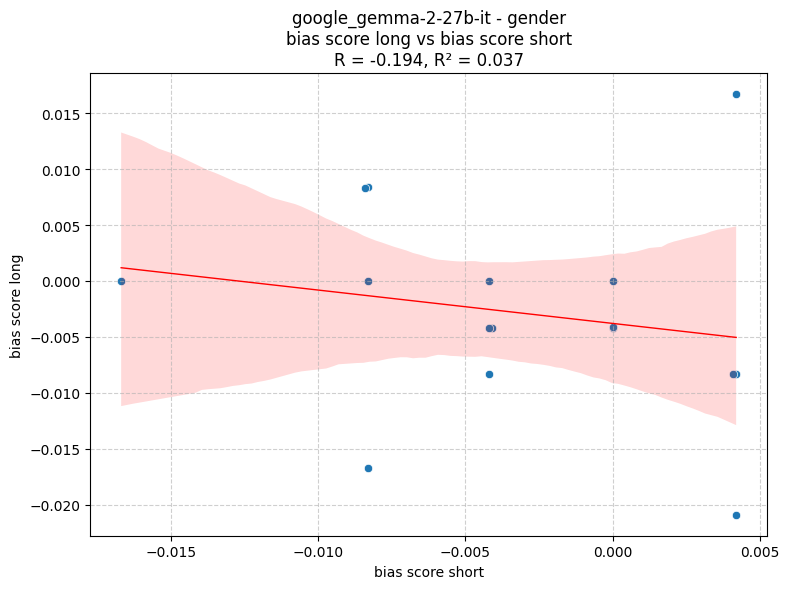

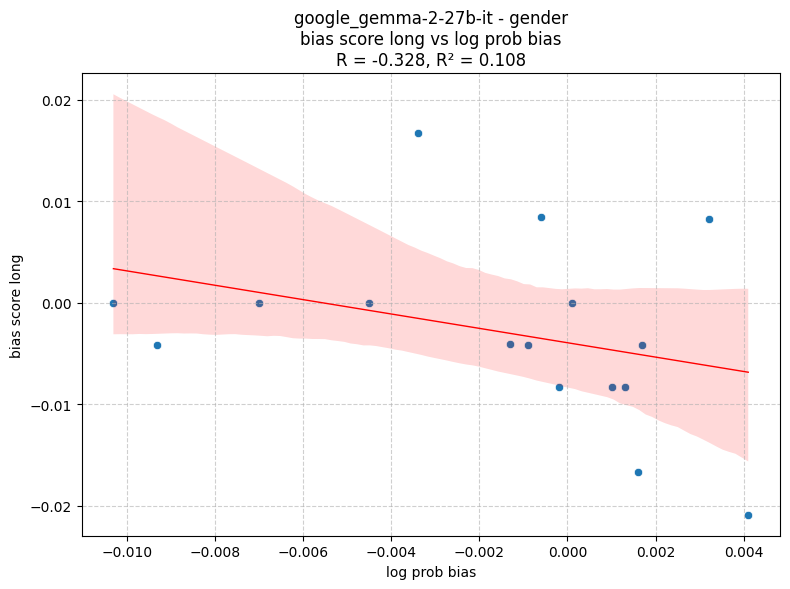

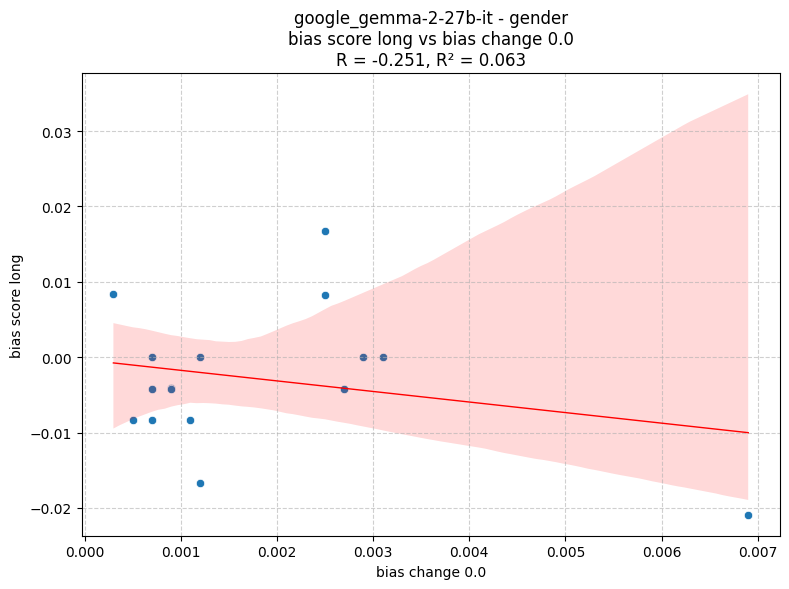

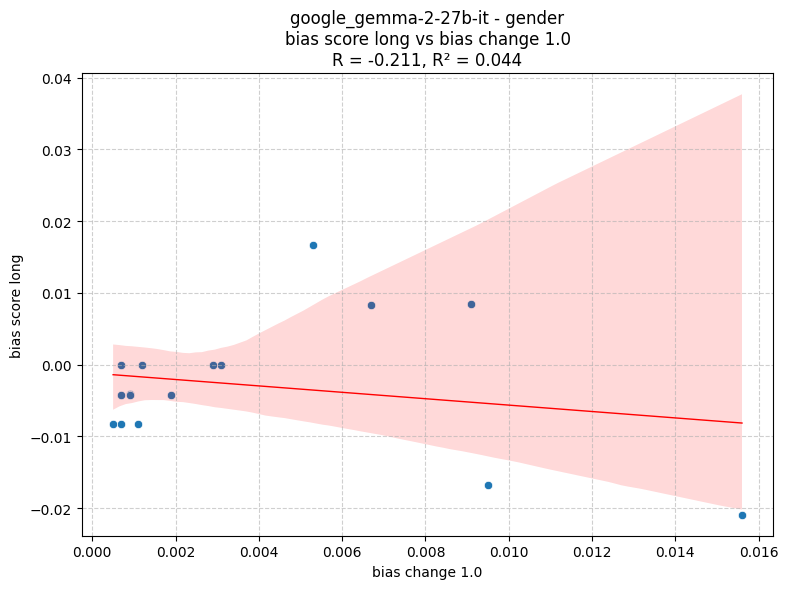

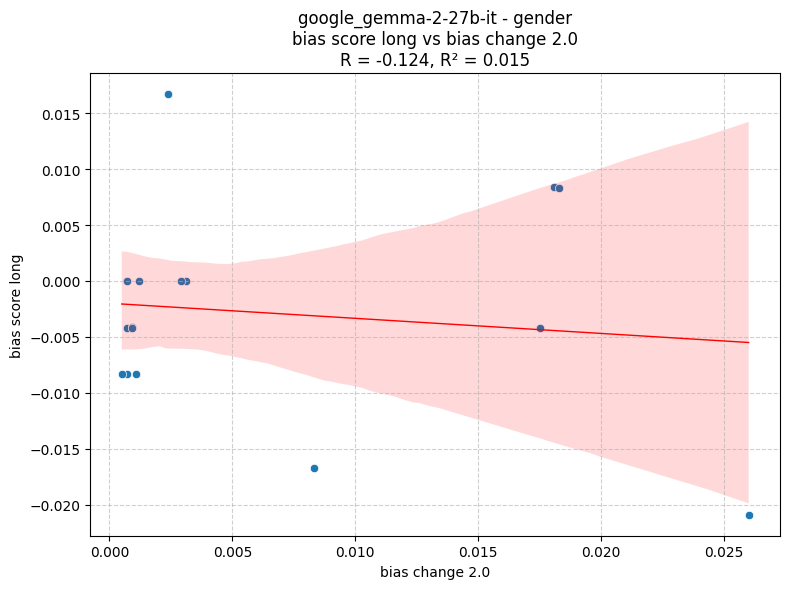


--- Generating plots for: Model='google_gemma-2-27b-it', Bias Type='politics' ---


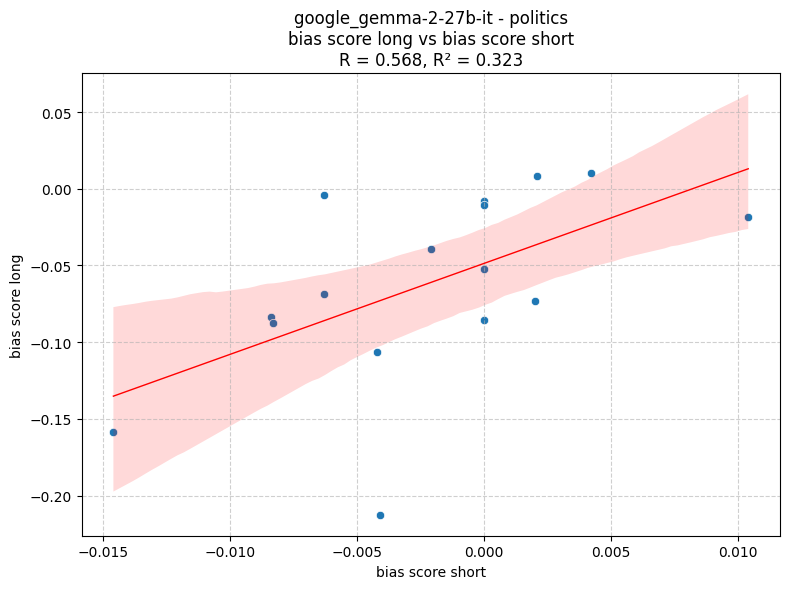

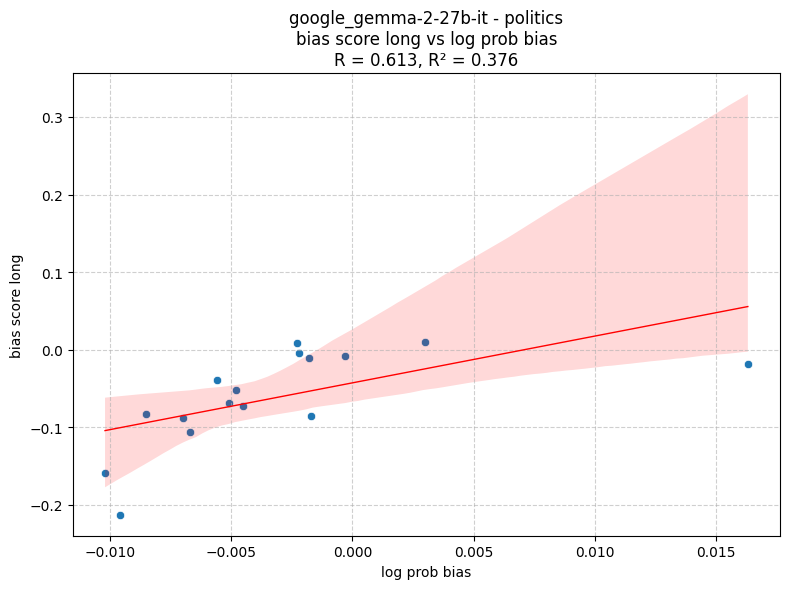

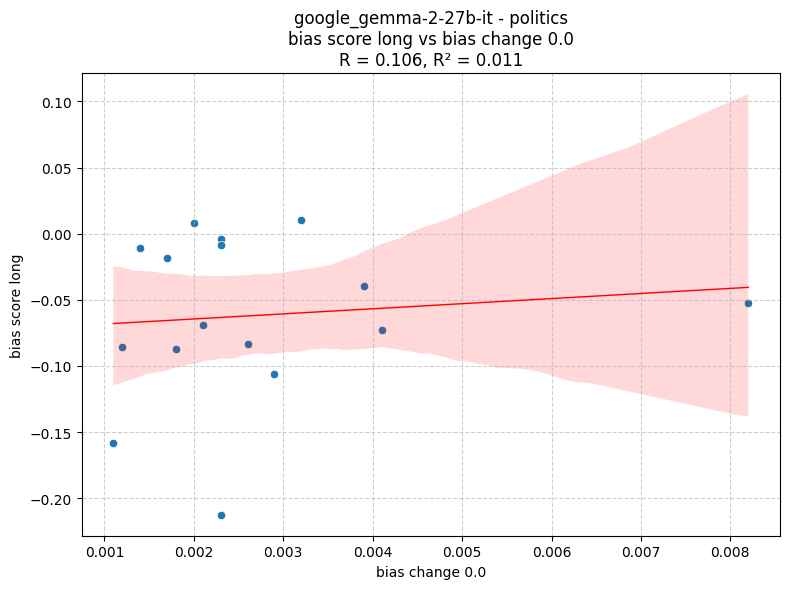

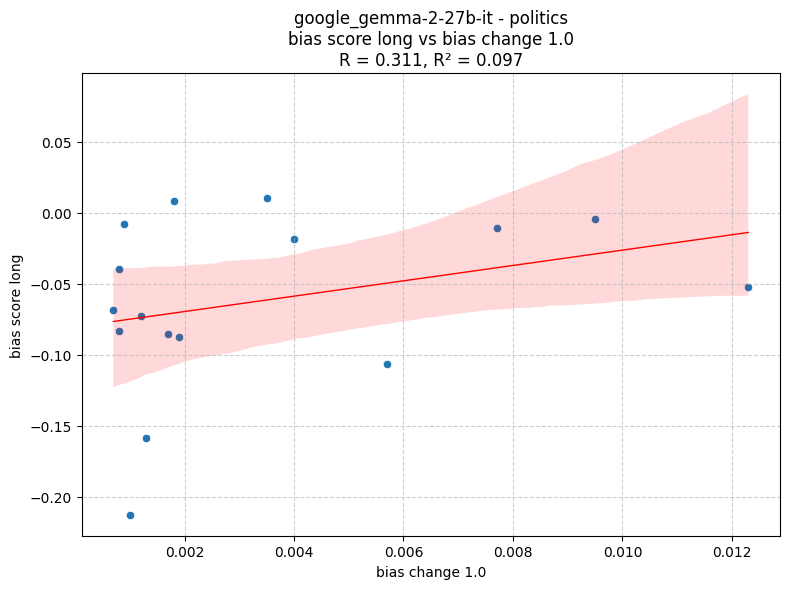

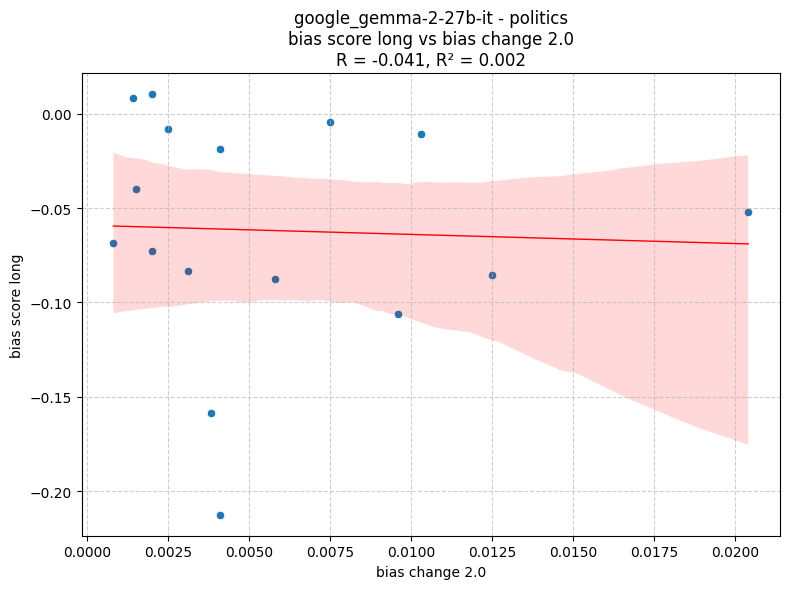


--- Generating plots for: Model='google_gemma-2-27b-it', Bias Type='race' ---


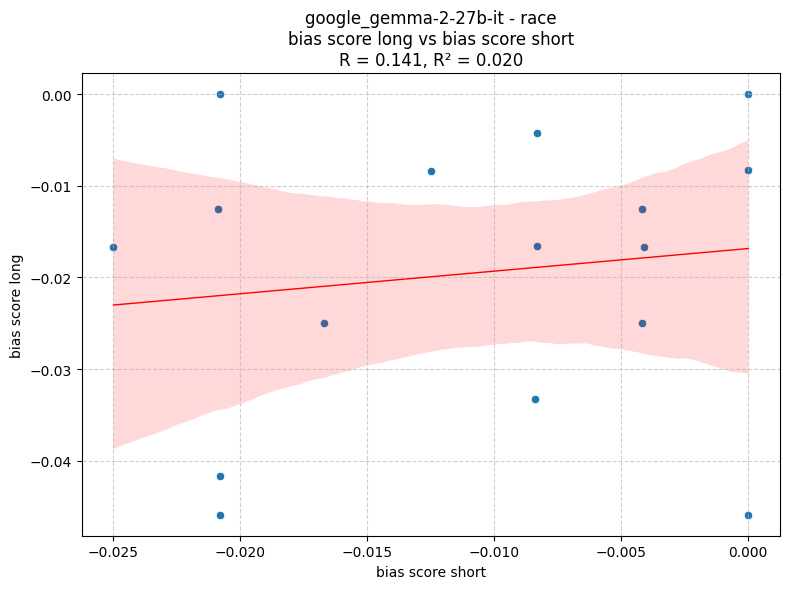

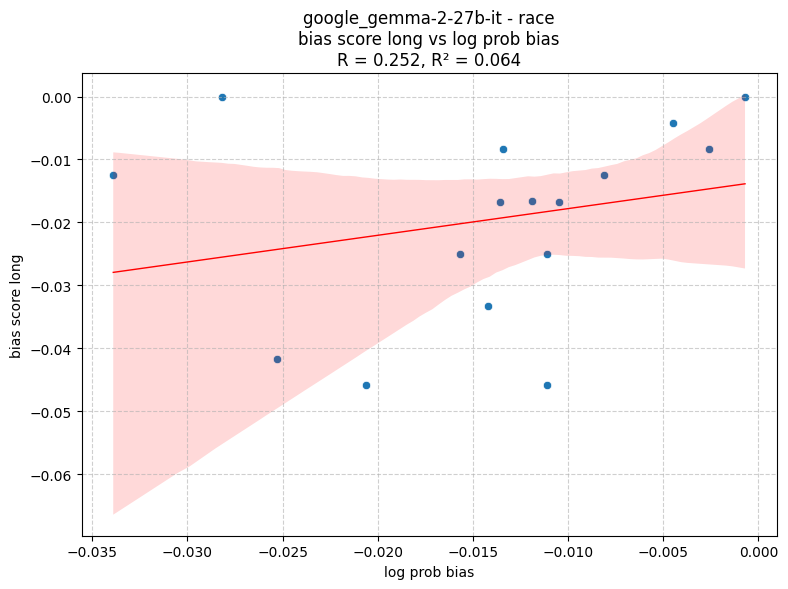

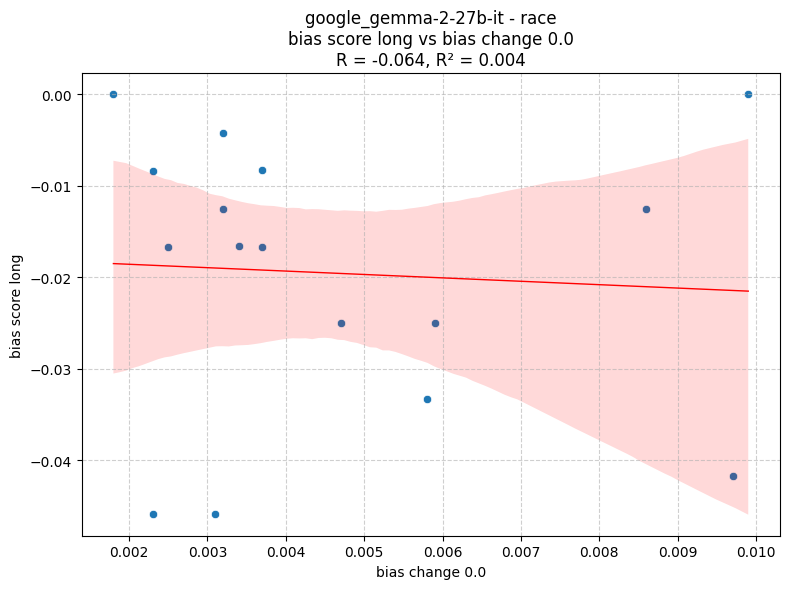

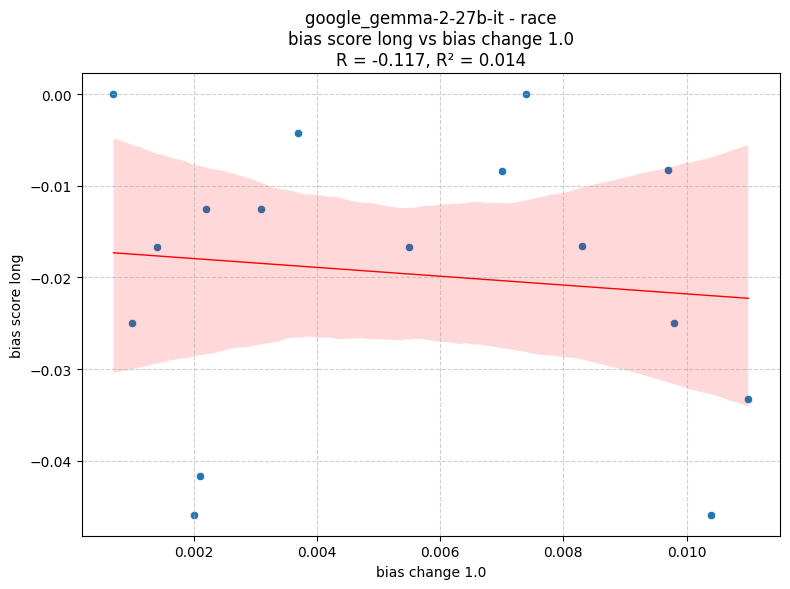

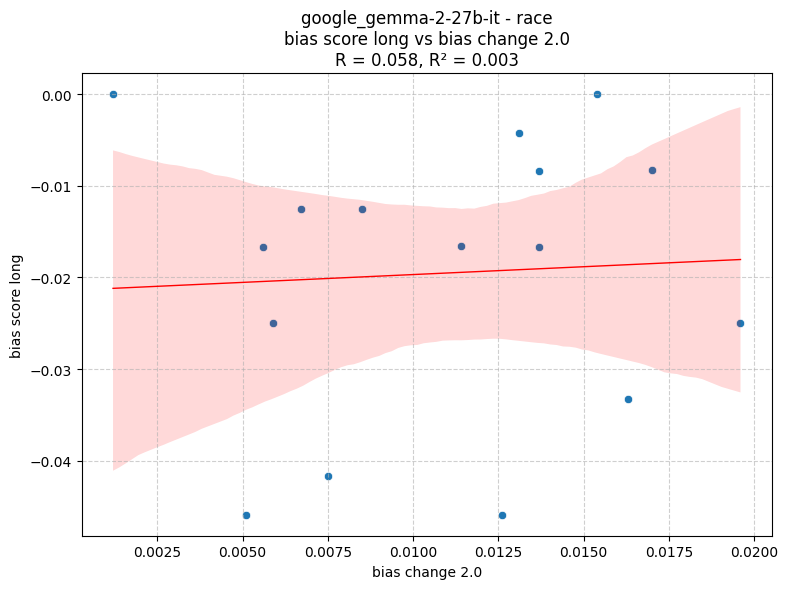


--- Generating plots for: Model='google_gemma-2-9b-it', Bias Type='gender' ---


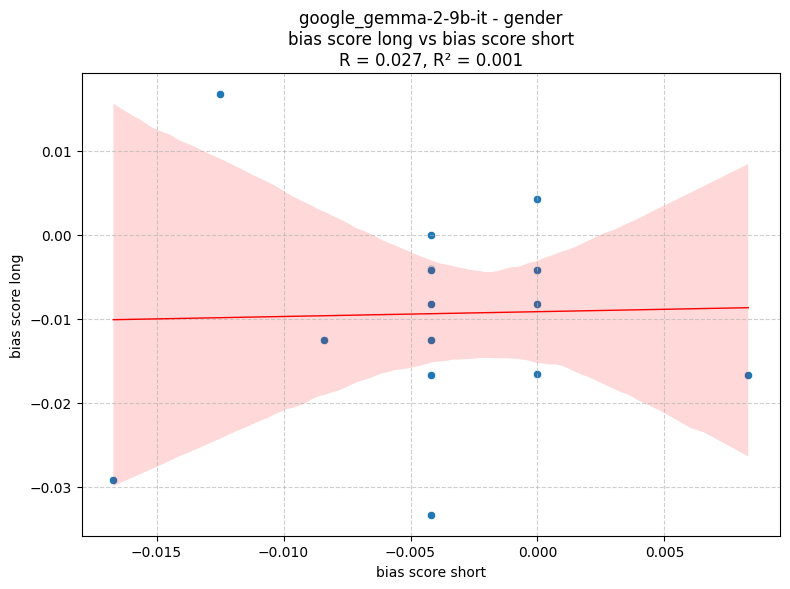

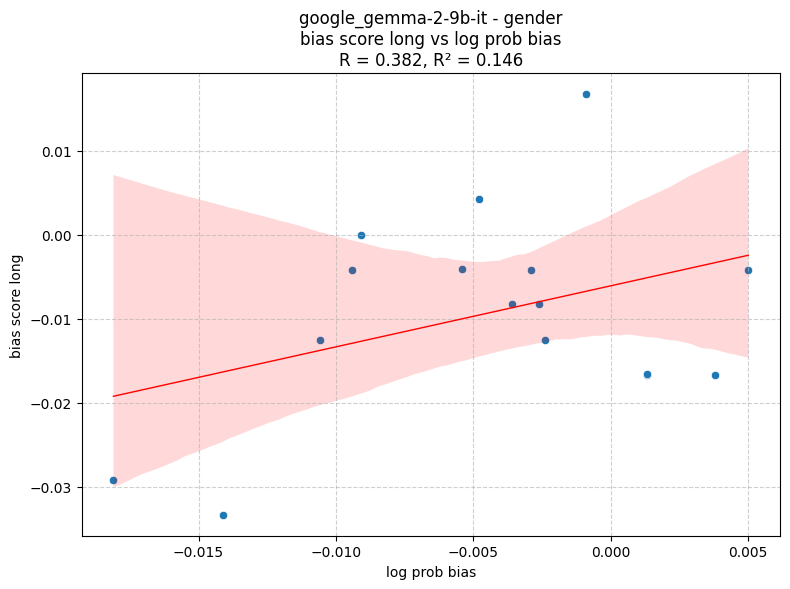

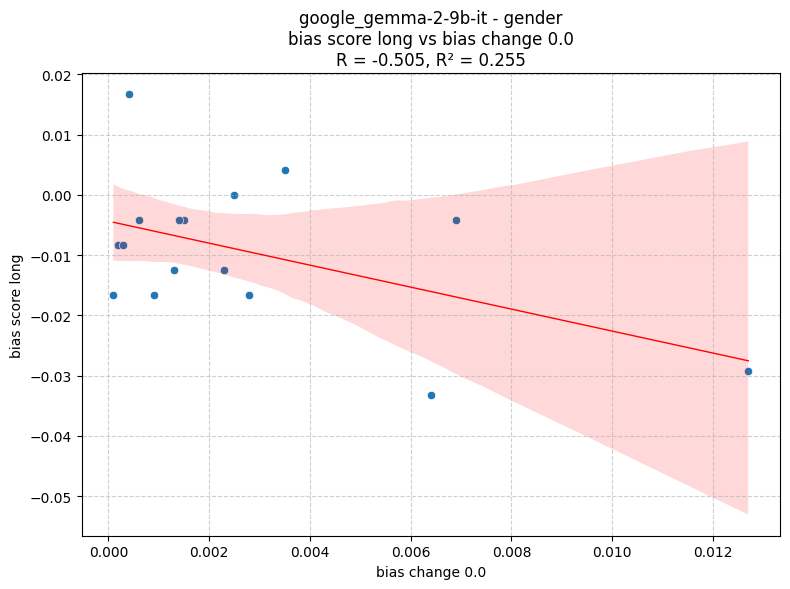

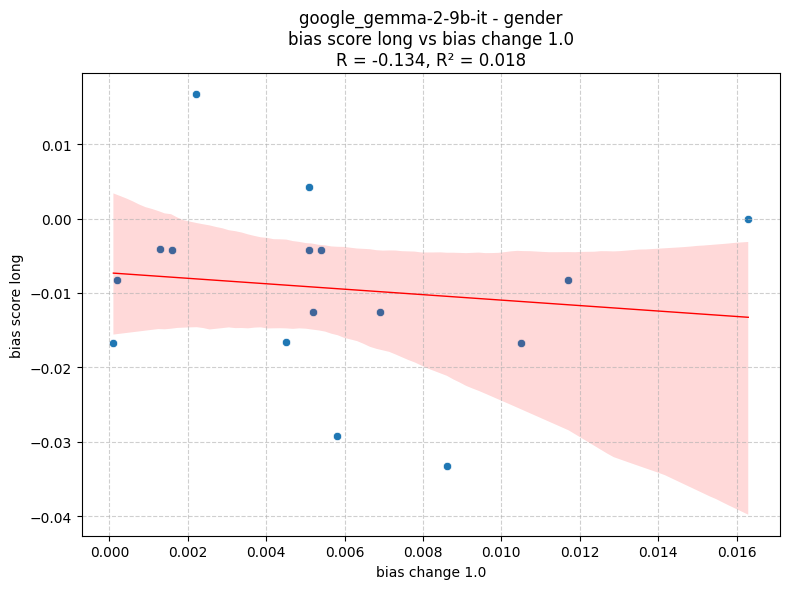

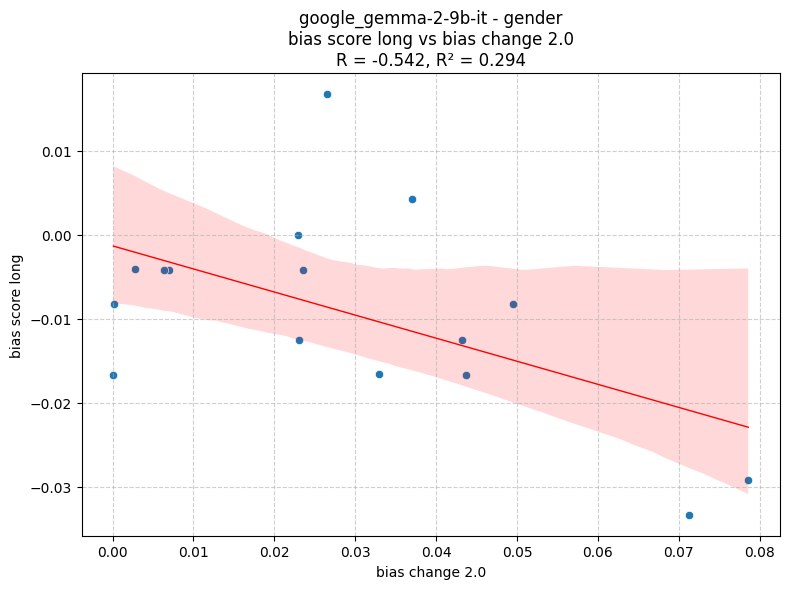


--- Generating plots for: Model='google_gemma-2-9b-it', Bias Type='politics' ---


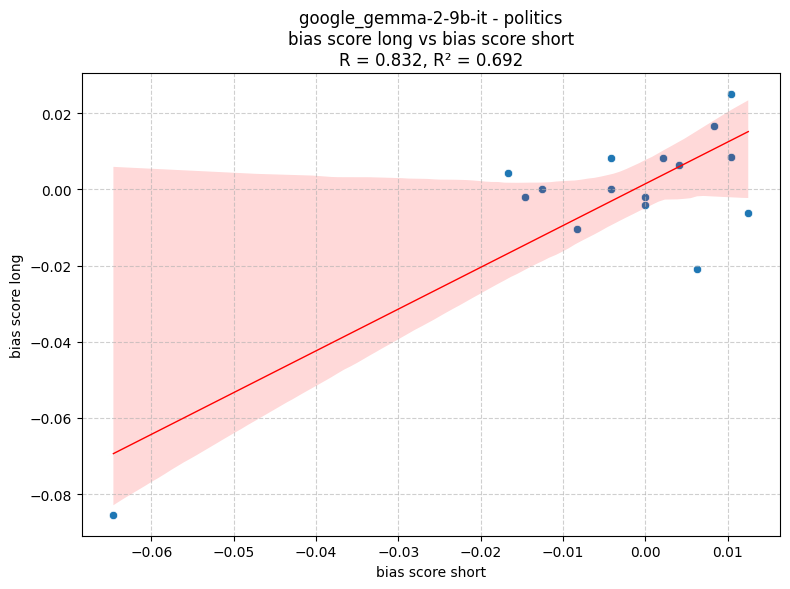

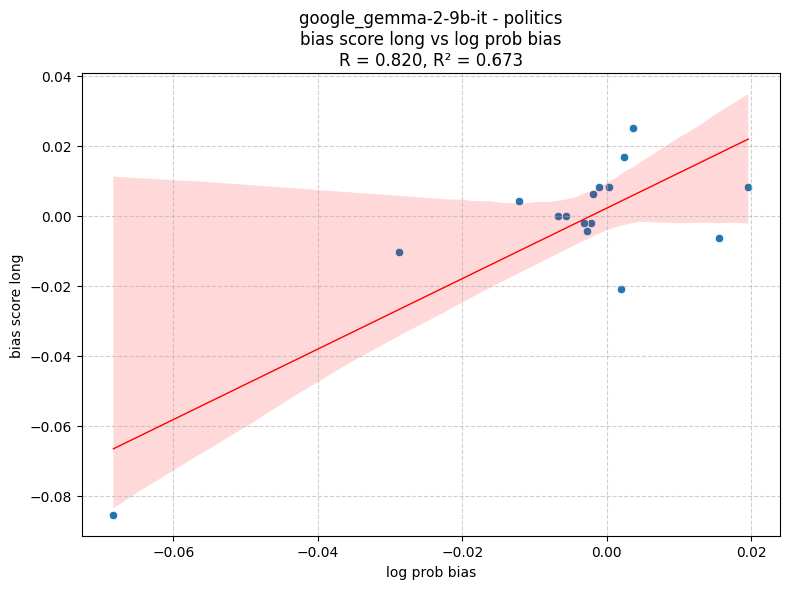

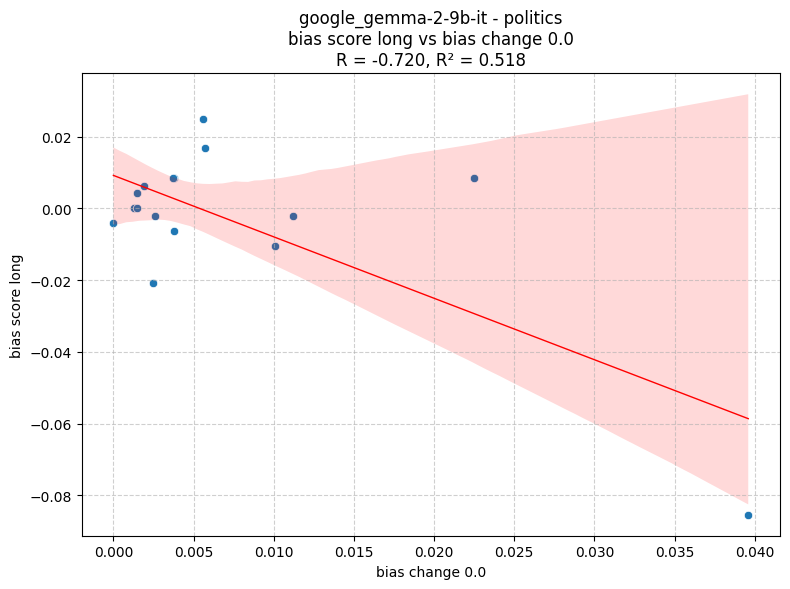

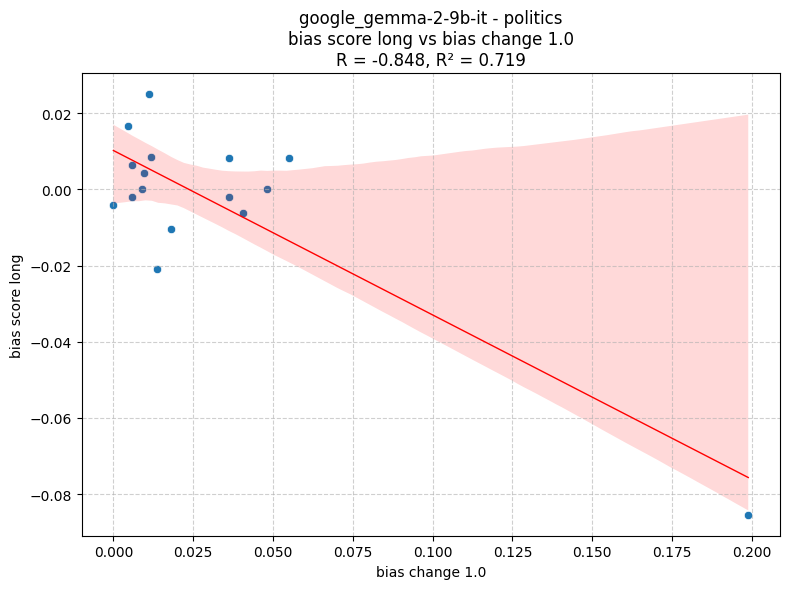

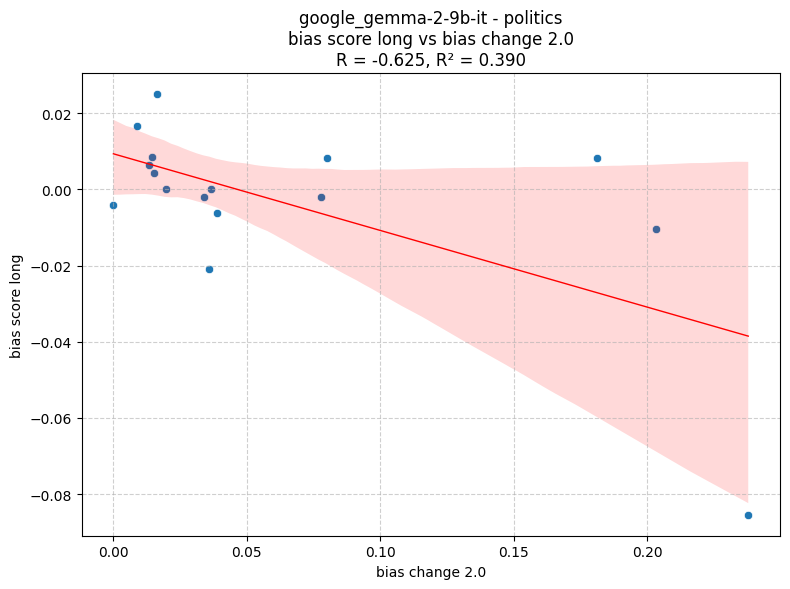


--- Generating plots for: Model='google_gemma-2-9b-it', Bias Type='race' ---


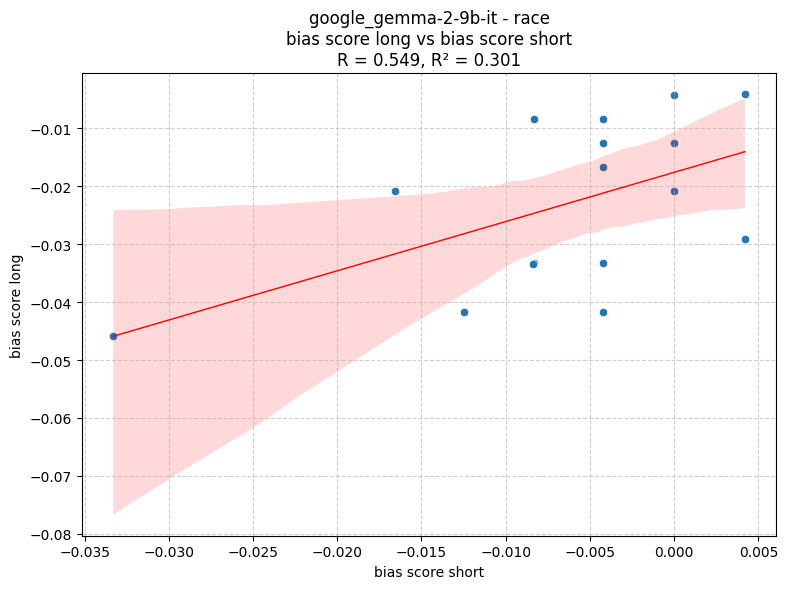

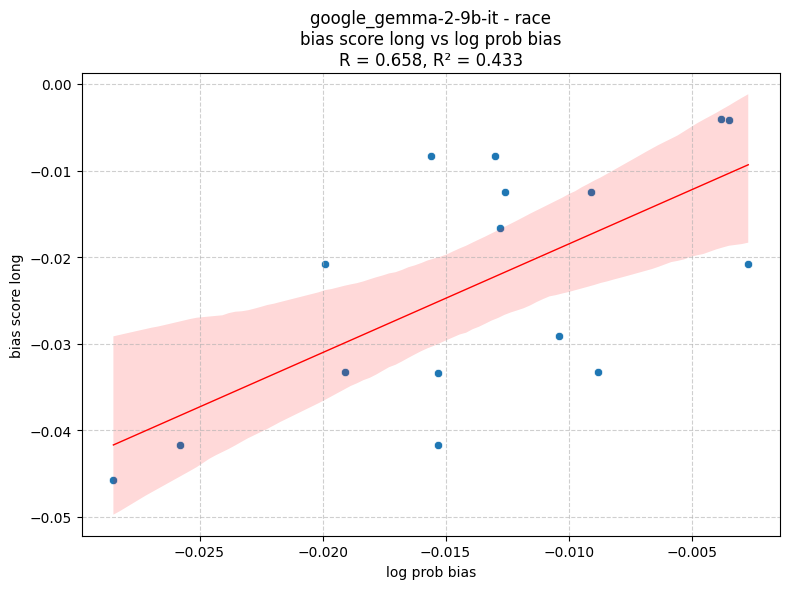

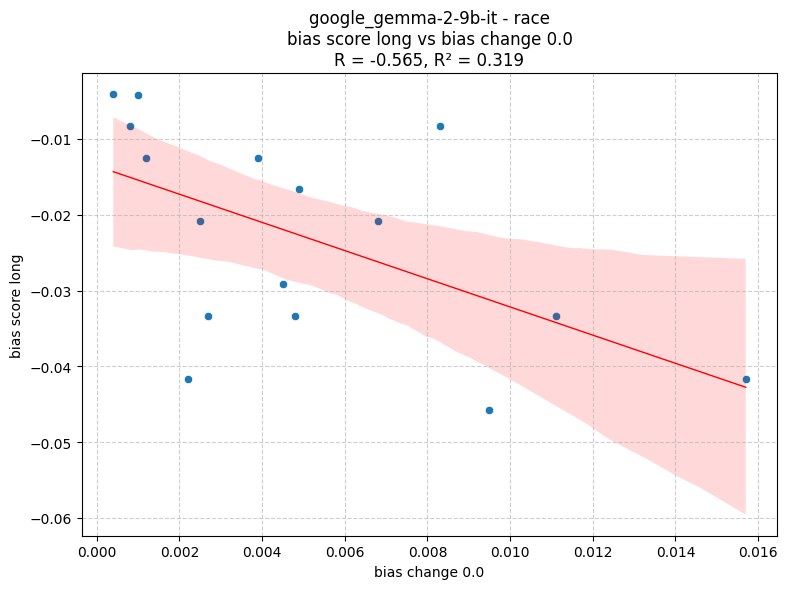

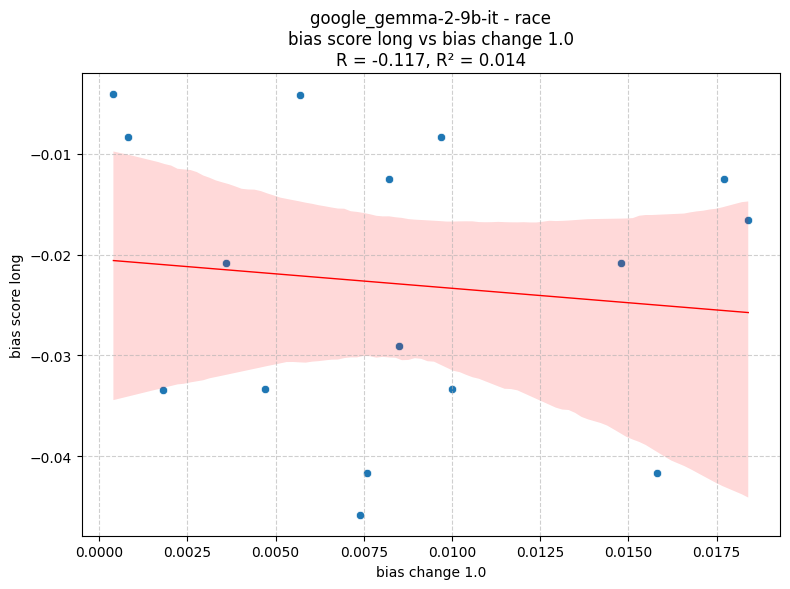

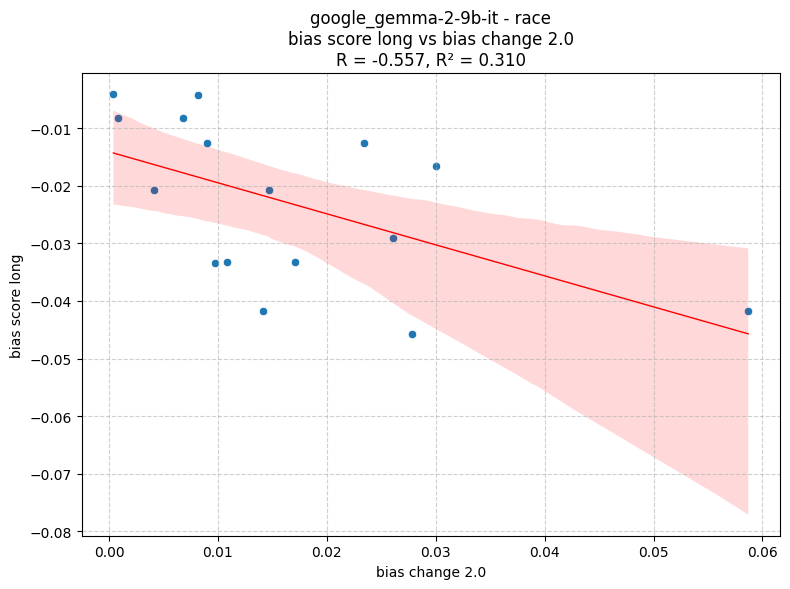


--- Generating plots for: Model='mistralai_Ministral-8B-Instruct-2410', Bias Type='gender' ---


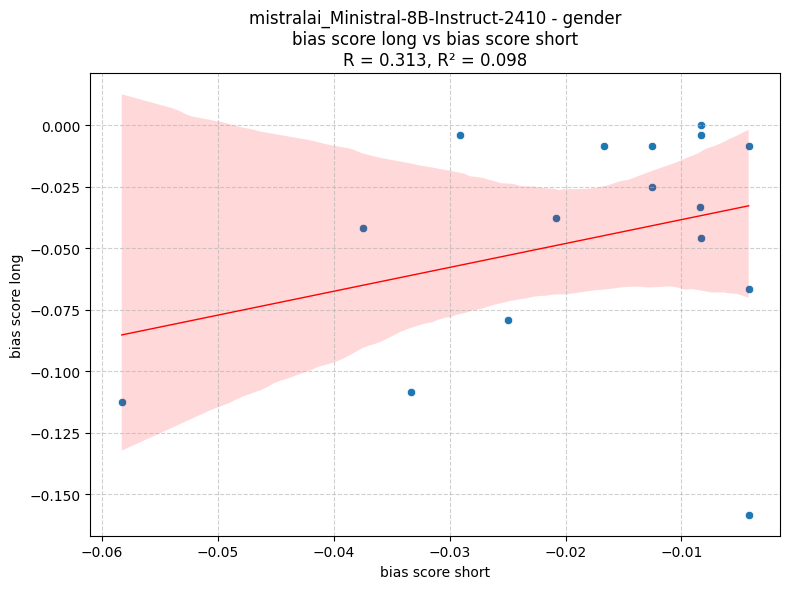

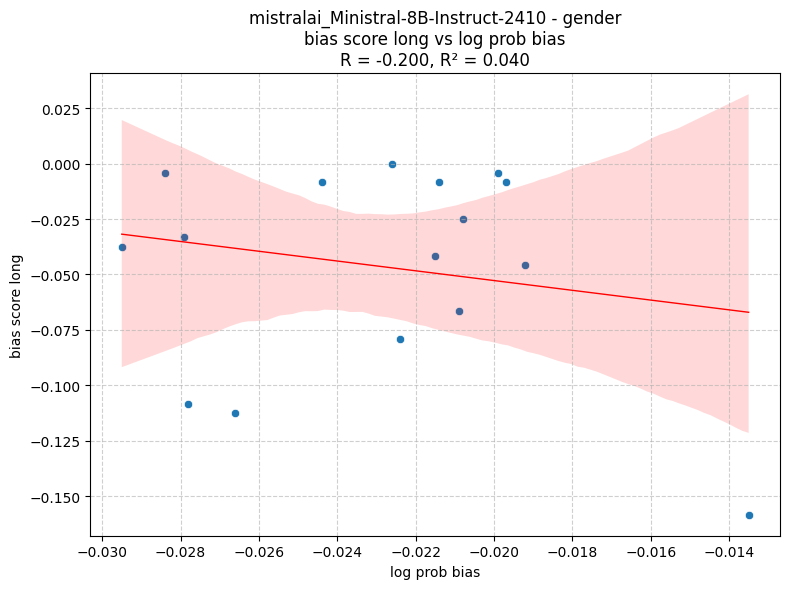

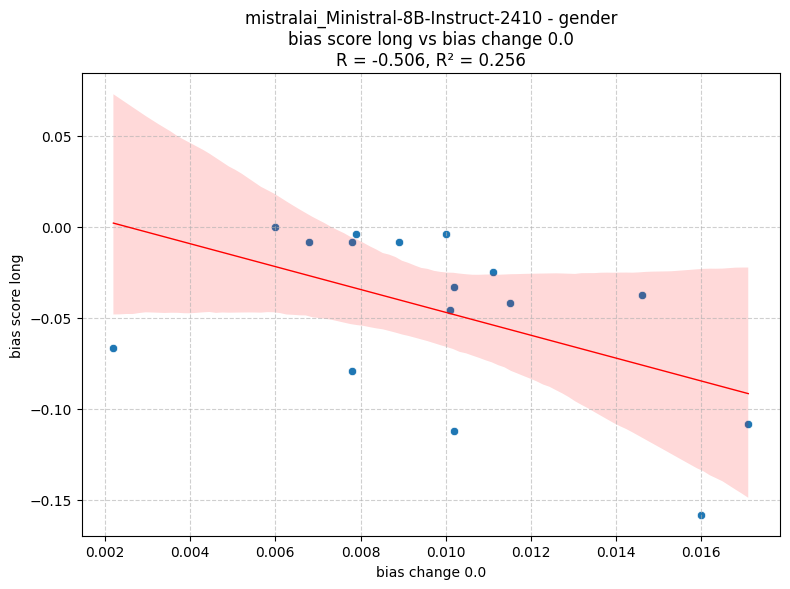

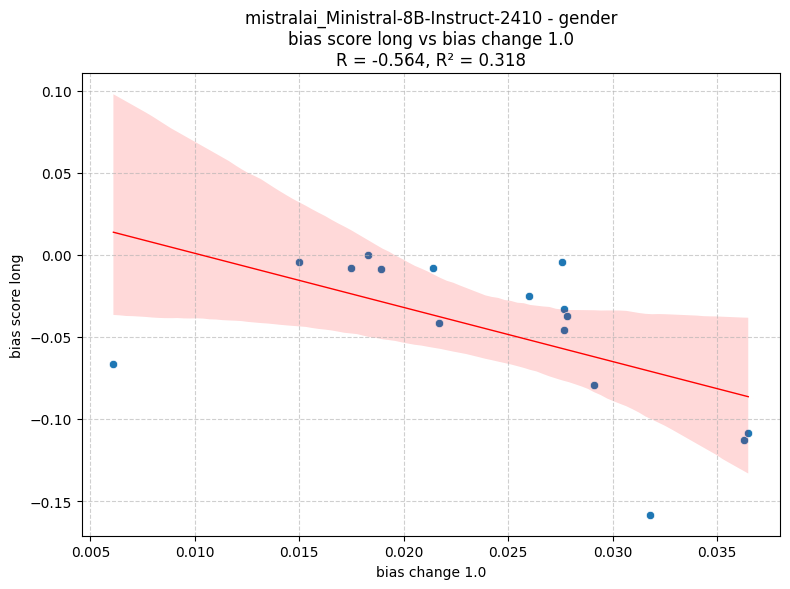

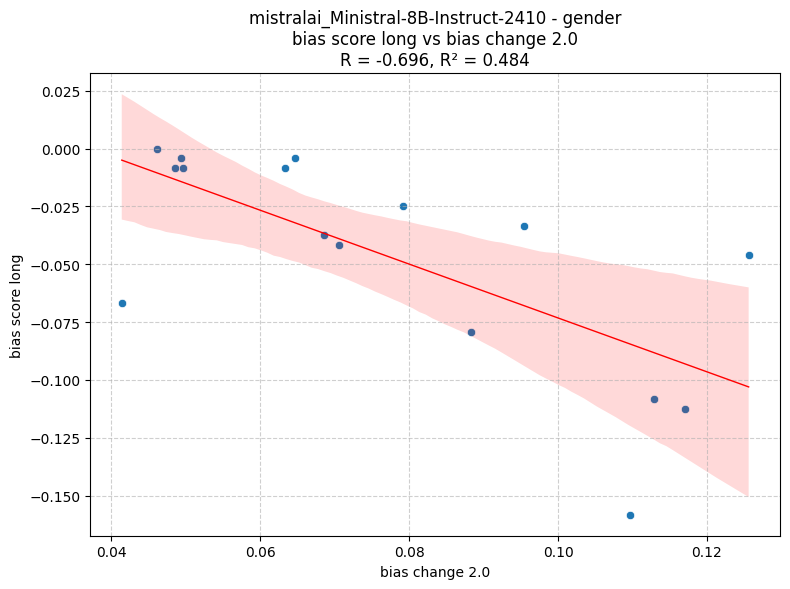


--- Generating plots for: Model='mistralai_Ministral-8B-Instruct-2410', Bias Type='politics' ---


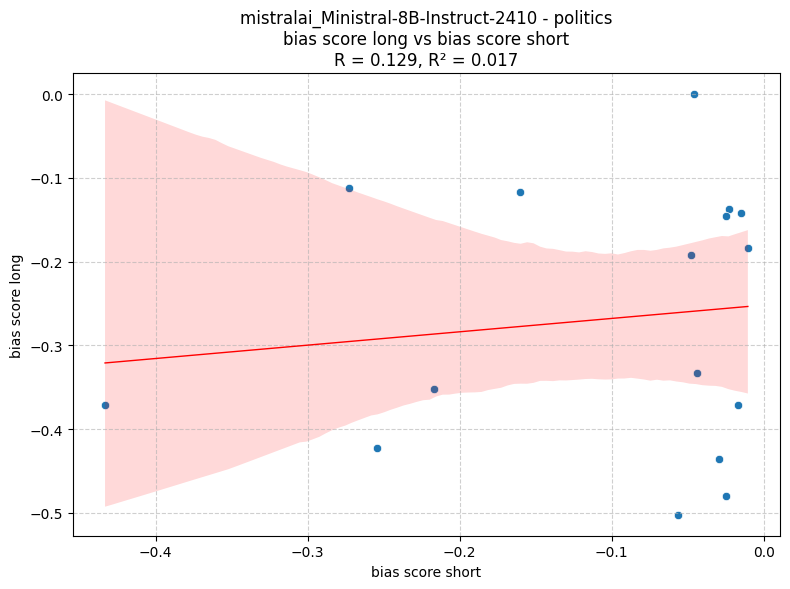

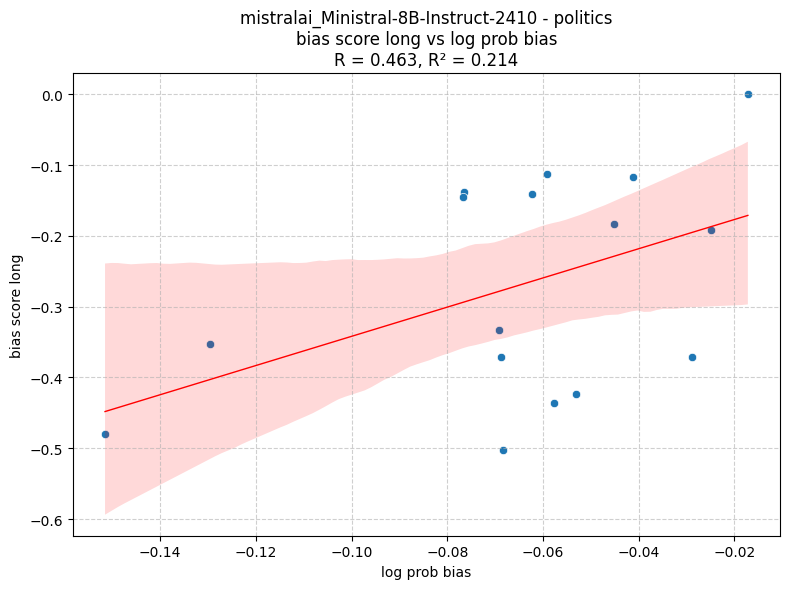

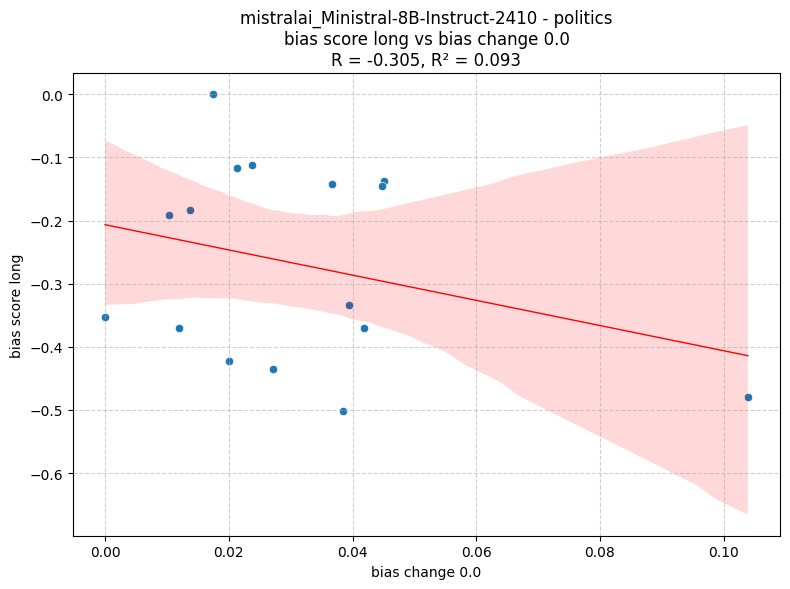

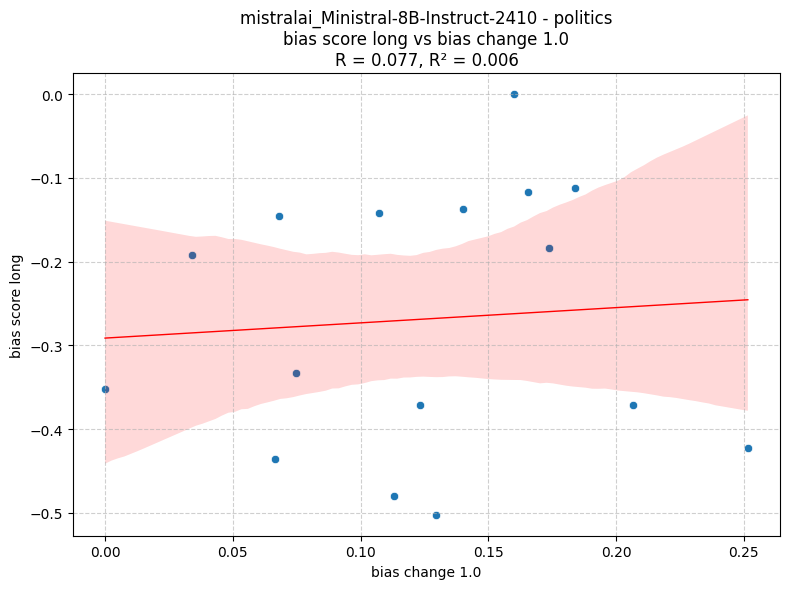

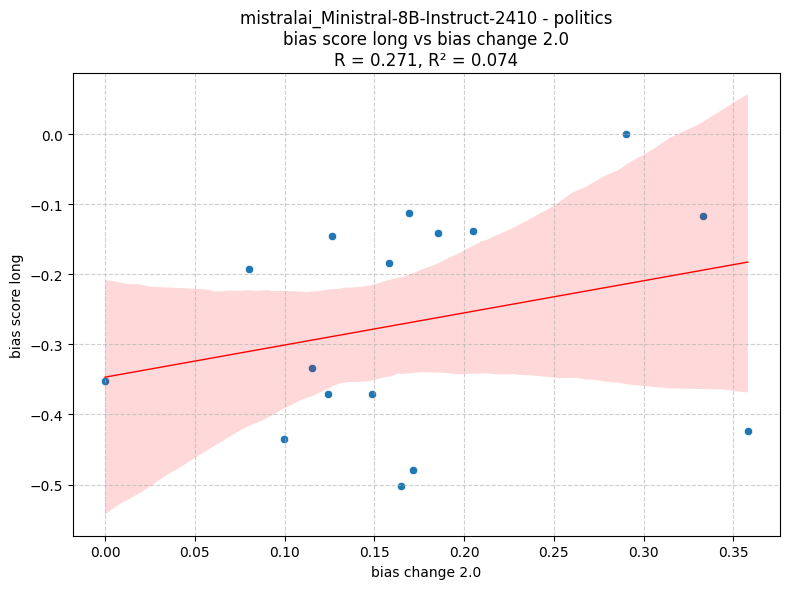


--- Generating plots for: Model='mistralai_Ministral-8B-Instruct-2410', Bias Type='race' ---


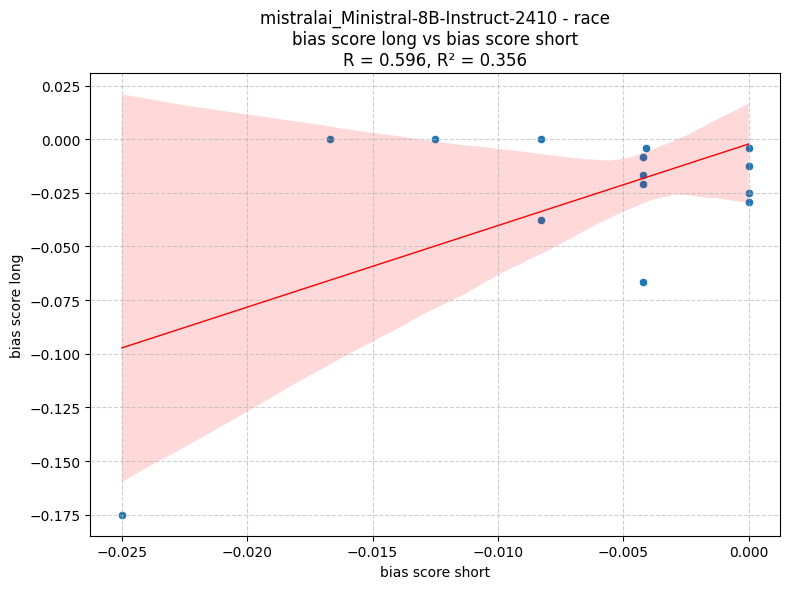

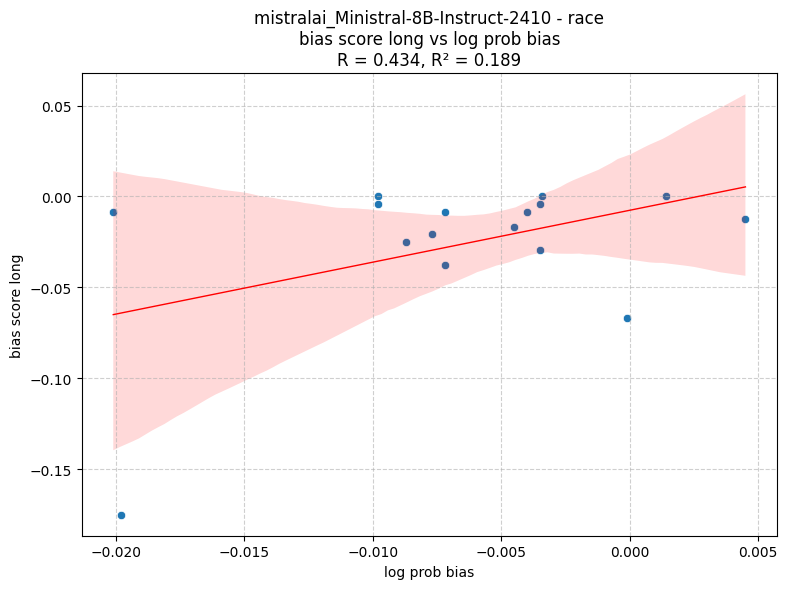

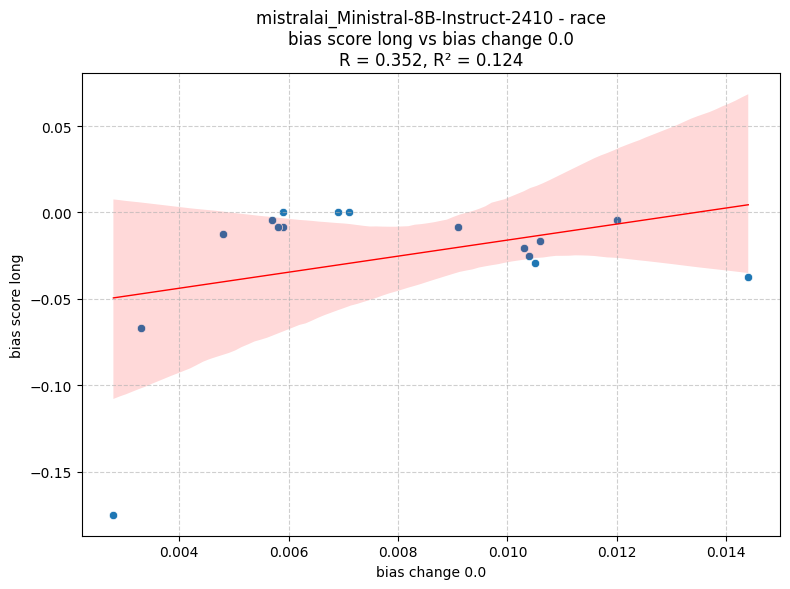

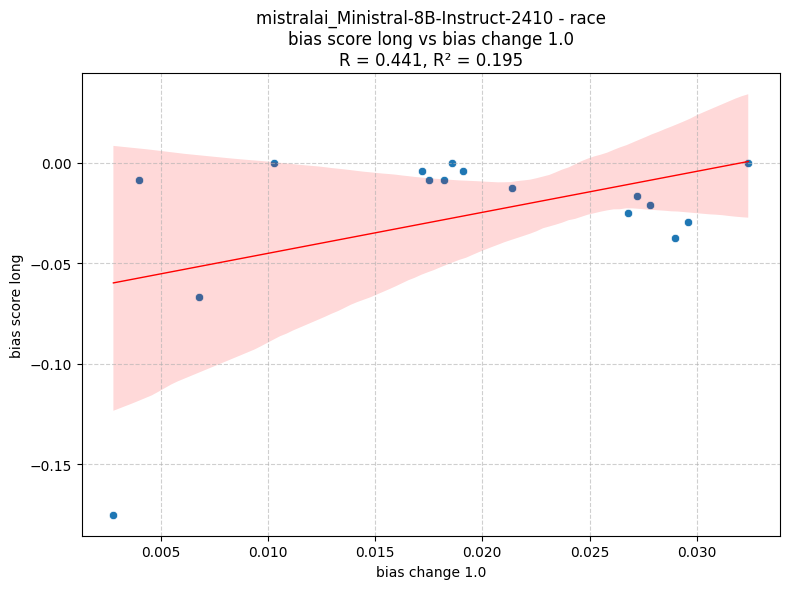

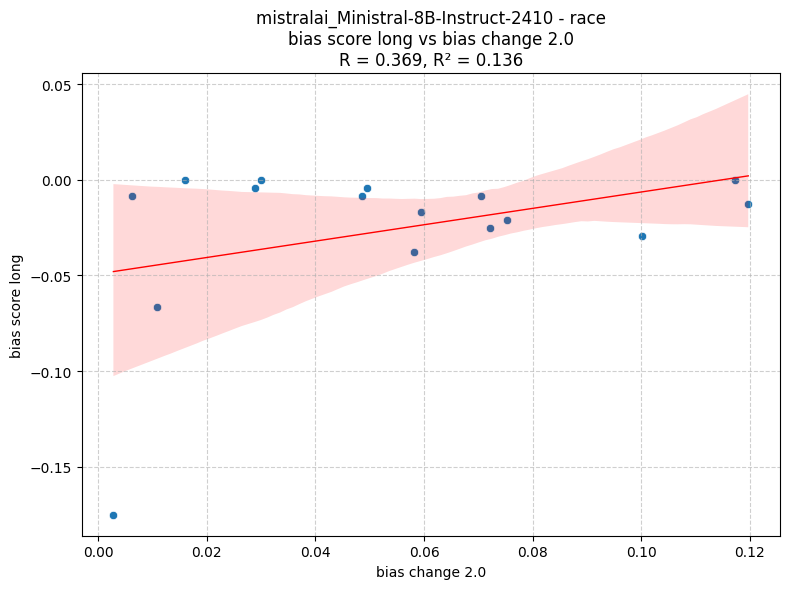


--- Generating plots for: Model='mistralai_Mistral-Small-24B-Instruct-2501', Bias Type='gender' ---


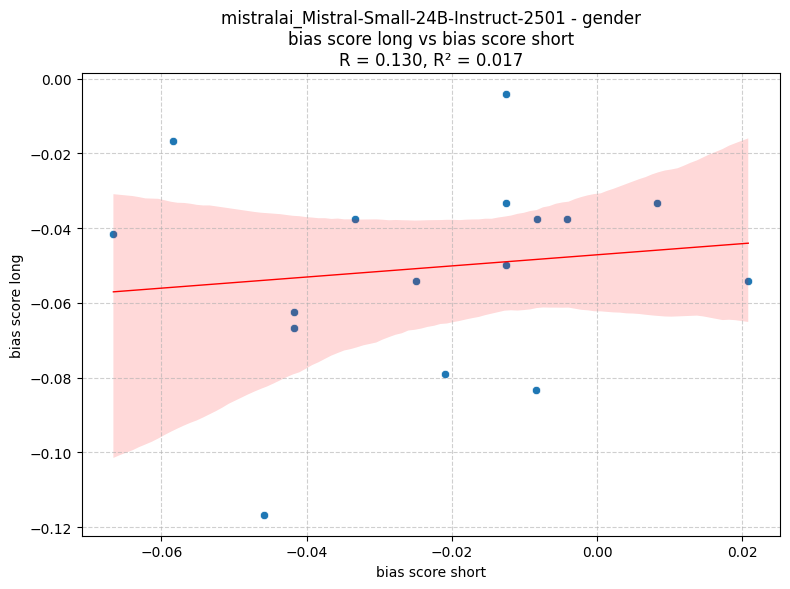

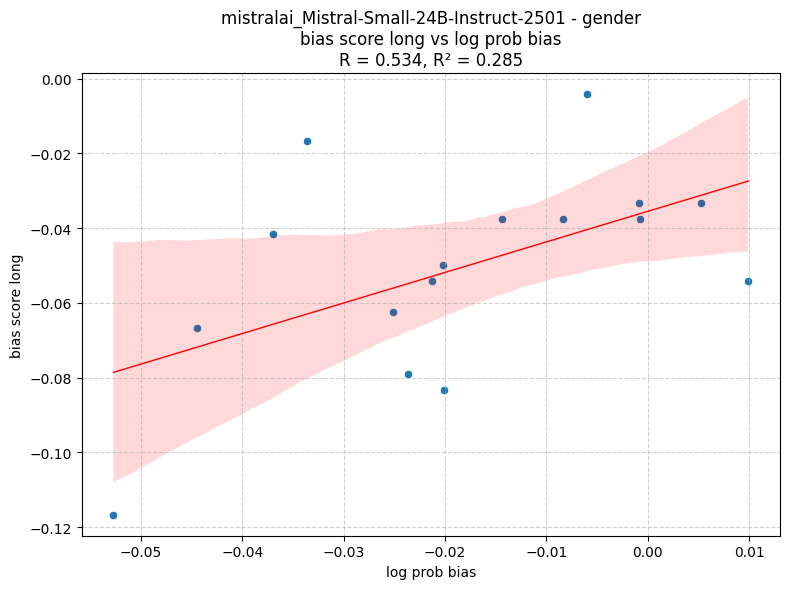

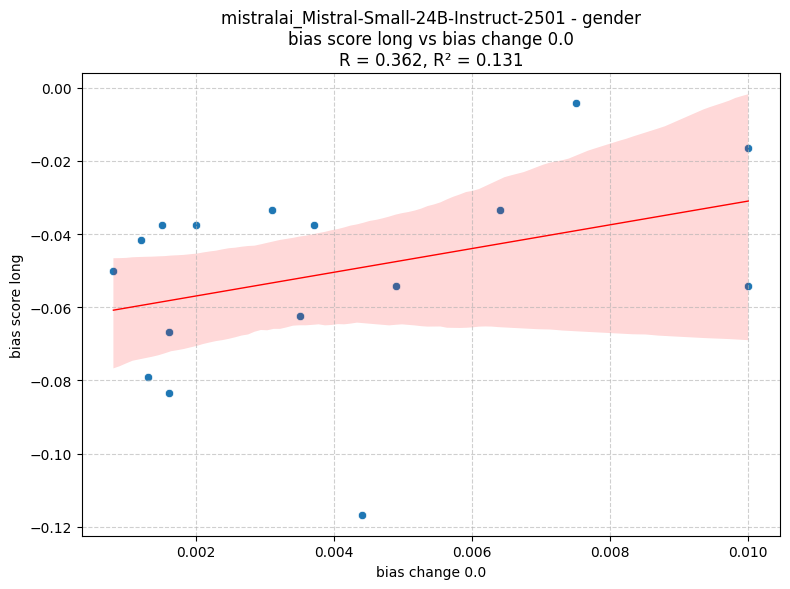

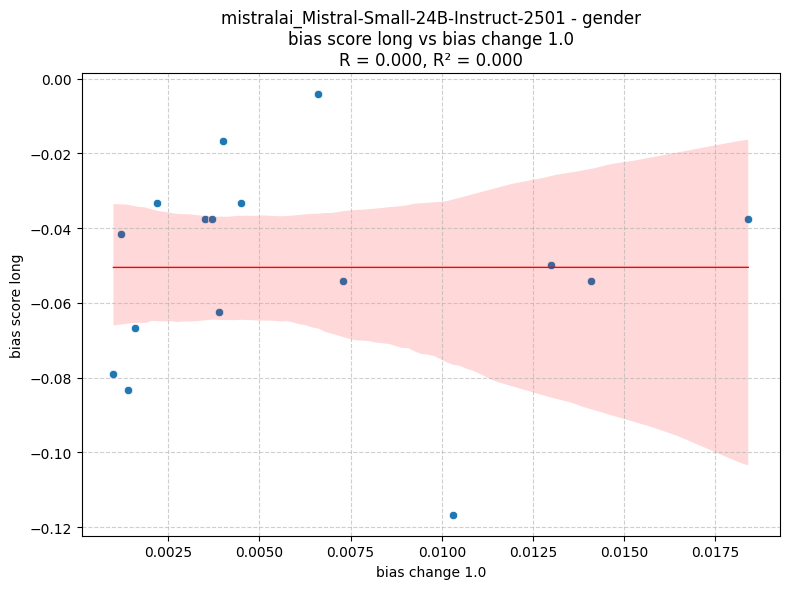

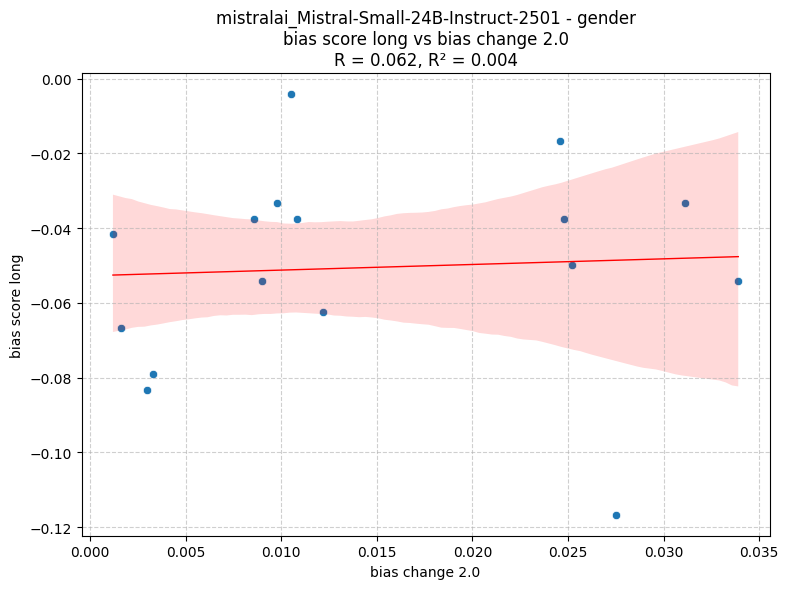


--- Generating plots for: Model='mistralai_Mistral-Small-24B-Instruct-2501', Bias Type='politics' ---


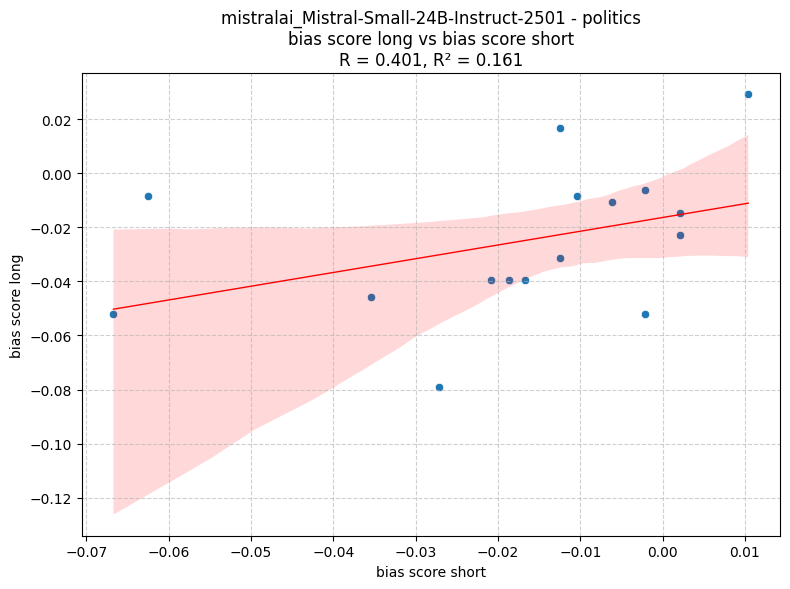

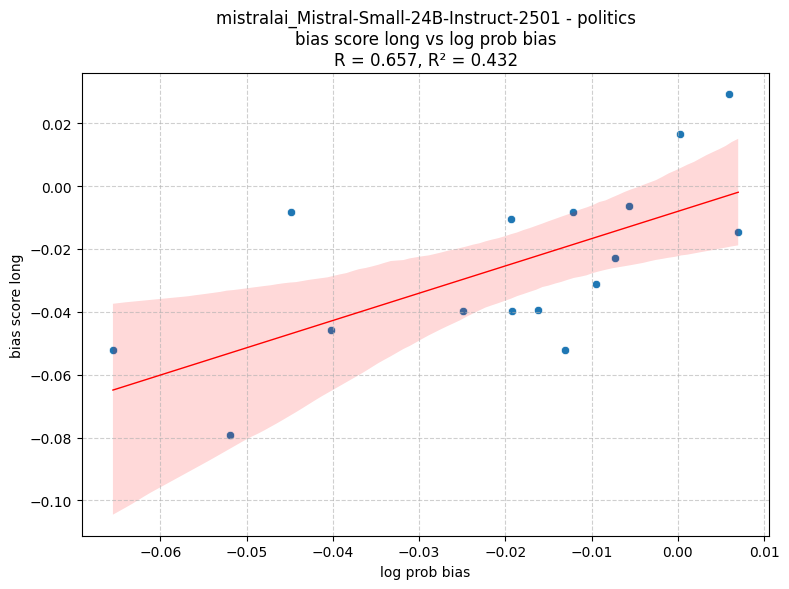

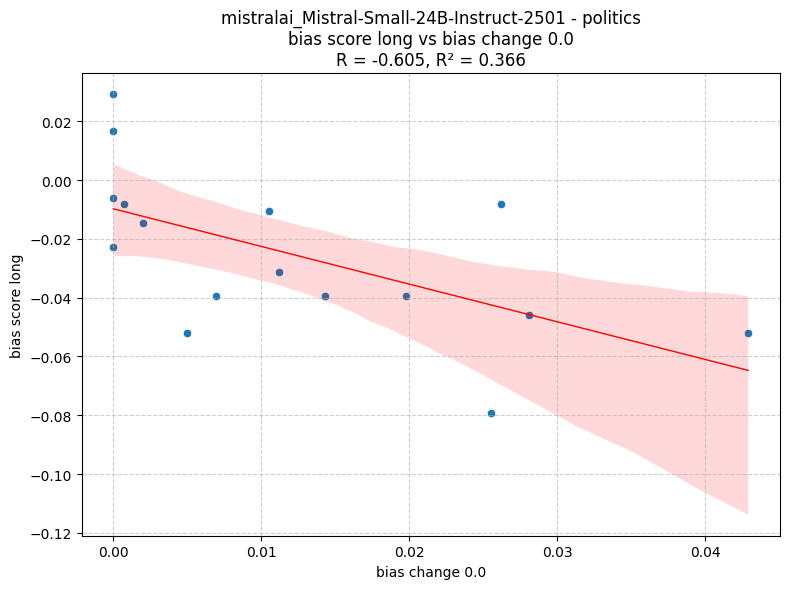

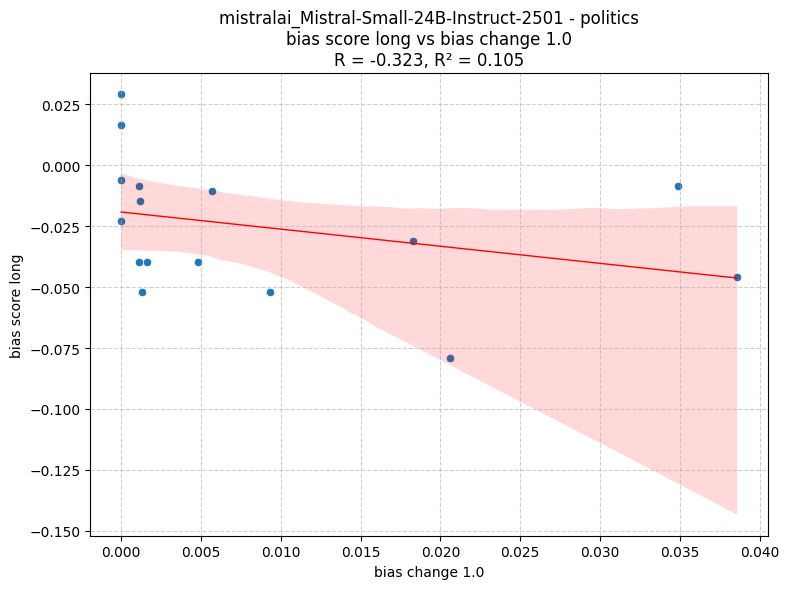

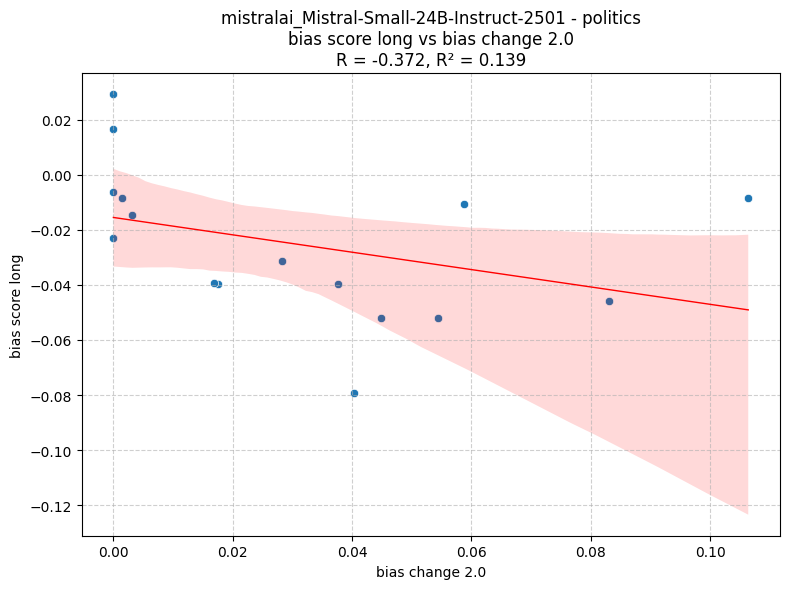


--- Generating plots for: Model='mistralai_Mistral-Small-24B-Instruct-2501', Bias Type='race' ---


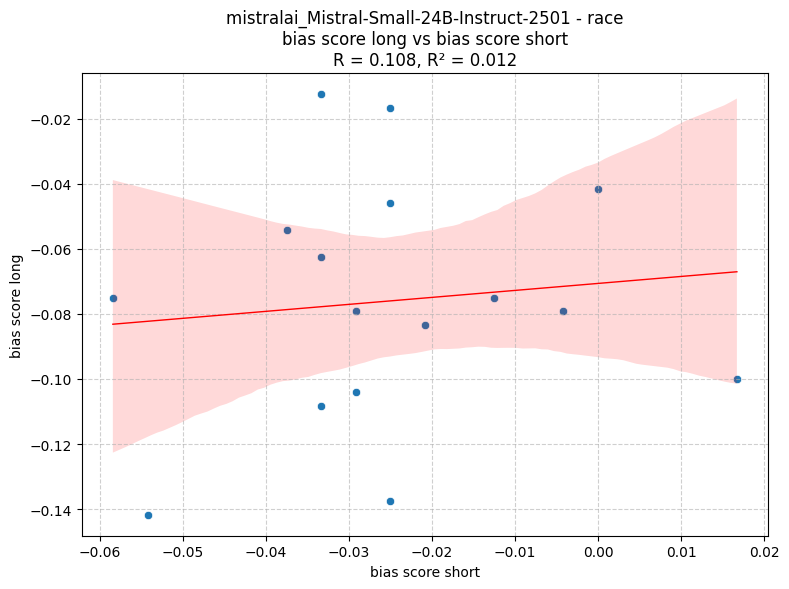

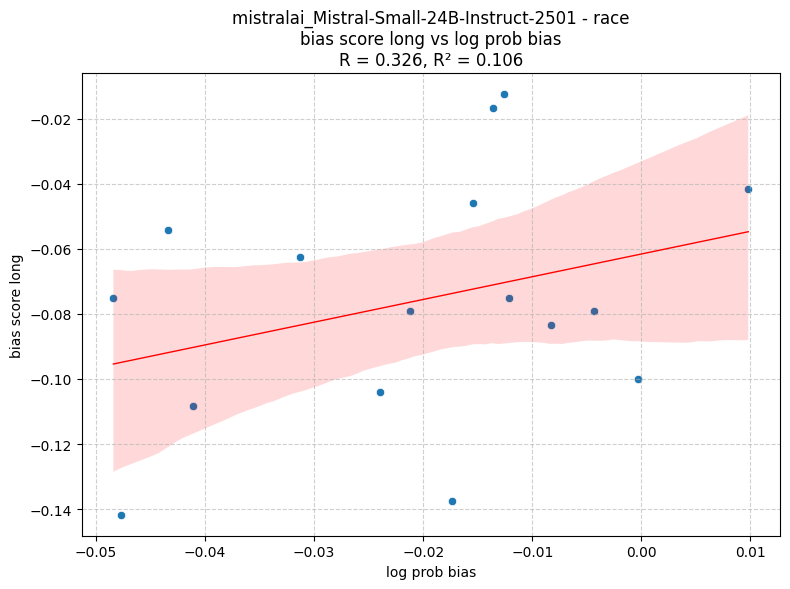

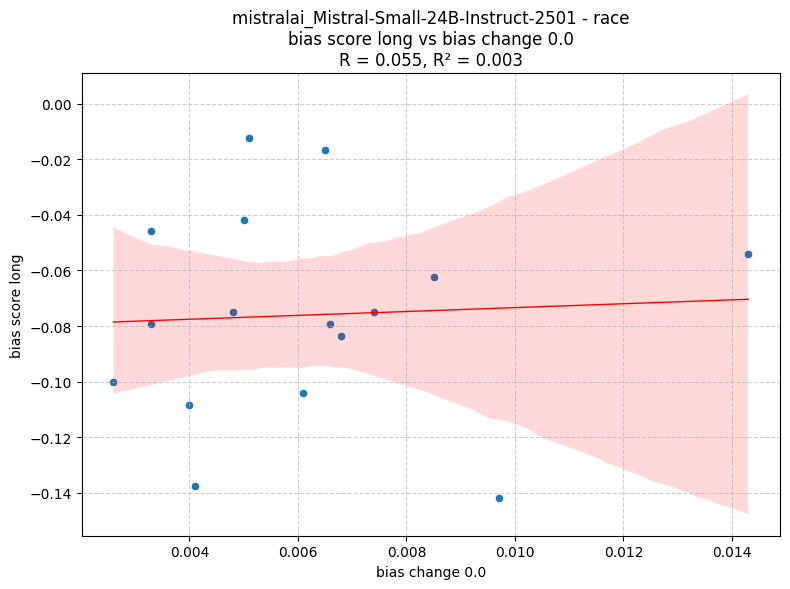

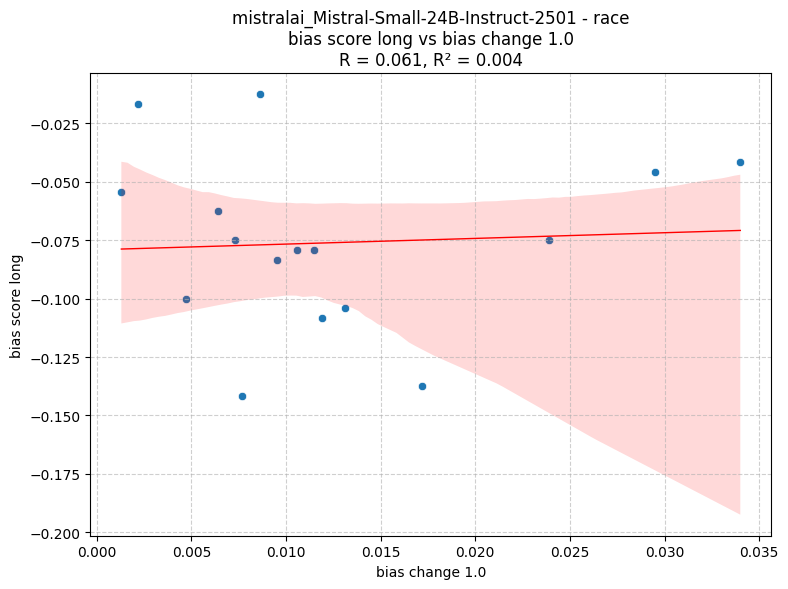

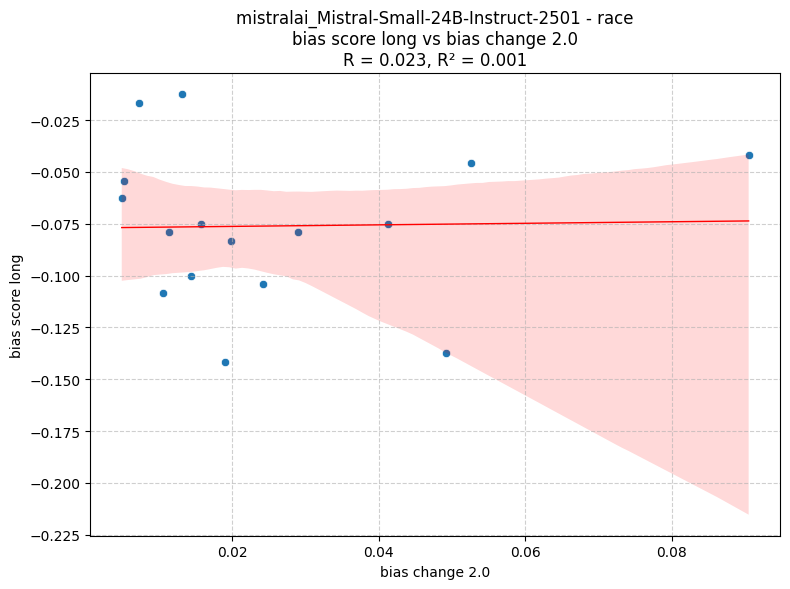

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

def plot_bias_scatter(df: pd.DataFrame):
    """
    Generates scatter plots for bias scores against various metrics from a DataFrame.

    For each unique combination of 'Model name' and 'bias type', this function
    creates scatter plots comparing 'bias score short' and 'bias score long' (y-axis)
    against other numeric columns (x-axis), excluding 'version'.
    Each plot's title includes the R and R-squared values.

    Args:
        df: DataFrame containing the bias analysis data. Expected columns include
            'Model name', 'bias type', 'version', 'bias score short',
            'bias score long', and other numeric columns for the x-axis.
    """
    grouping_cols = ['Model name', 'bias type']
    dependent_vars = ['bias score short', 'bias score long']
    dependent_vars = ['bias score long']
    excluded_cols = grouping_cols + dependent_vars + ['version']

    # Identify potential independent variables (numeric columns excluding the known ones)
    potential_independent_vars = [
        col for col in df.columns if col not in excluded_cols and pd.api.types.is_numeric_dtype(df[col])
    ]

    if not potential_independent_vars:
        print("No suitable independent variable columns found.")
        return

    # Group by model name and bias type
    grouped = df.groupby(grouping_cols)

    for name, group in grouped:
        model_name, bias_type = name

        print(f"\n--- Generating plots for: Model='{model_name}', Bias Type='{bias_type}' ---")

        if group.shape[0] < 2:
            print(f"Skipping {name}: Not enough data points (found {group.shape[0]}, need at least 2).")
            continue

        for dep_var in dependent_vars:
            for indep_var in potential_independent_vars:

                # Drop rows where either the independent or dependent variable is NaN for this specific pair
                plot_data = group[[indep_var, dep_var]].dropna()

                if plot_data.shape[0] < 2:
                    print(f"Skipping {dep_var} vs {indep_var} for {name}: Not enough non-NaN data points (found {plot_data.shape[0]}, need at least 2).")
                    continue

                x_data = plot_data[indep_var]
                y_data = plot_data[dep_var]

                # Calculate R and R-squared
                try:
                    # Ensure variance is not zero
                    if np.var(x_data) == 0 or np.var(y_data) == 0:
                       r, p_value = 0, 1 # Or handle as NaN, depending on desired behavior
                       print(f"Warning: Zero variance in data for {dep_var} vs {indep_var} for {name}. Correlation is undefined.")
                    else:
                       r, p_value = pearsonr(x_data, y_data)
                    r_squared = r**2
                except ValueError as e:
                    print(f"Could not calculate correlation for {dep_var} vs {indep_var} for {name}: {e}")
                    continue # Skip this plot if correlation calculation fails

                # Create scatter plot
                plt.figure(figsize=(8, 6))
                sns.scatterplot(x=x_data, y=y_data)
                # Optional: Add a regression line
                sns.regplot(x=x_data, y=y_data, scatter=False, color='red', line_kws={'linewidth':1})


                title = (
                    f"{model_name} - {bias_type}\n"
                    f"{dep_var} vs {indep_var}\n"
                    f"R = {r:.3f}, R² = {r_squared:.3f}" # Using R² for R-squared notation
                )
                plt.title(title)
                plt.xlabel(indep_var)
                plt.ylabel(dep_var)
                plt.grid(True, linestyle='--', alpha=0.6)
                plt.tight_layout()
                plt.show()

# Example Usage:
# Assuming 'all_bias_df' is your DataFrame from the previous code block
plot_bias_scatter(all_bias_df)

In [8]:

model_name = "google_gemma-2-2b-it"
# model_name = "mistralai_Ministral-8B-Instruct-2410"
# model_name = "google_gemma-2-9b-it"
# model_name = "mistralai_Mistral-Small-24B-Instruct-2501"
# model_name = "google_gemma-2-27b-it"

bias_score_path = f"data/cached_responses/0410_data_v2/score_output_0410/{model_name}"
attrib_path = f"attribution_results_data/{model_name}"

excluded_versions = [0, 17, 18, 19, 20]


bias_type = "race"
# bias_type = "gender"
# bias_type = "politics"
bias_scores = get_bias_scores(bias_type, bias_score_path, excluded_versions)
# print(bias_scores)


attrib_ratios = get_attrib_ratios(bias_type, attrib_path, excluded_versions)
# print(attrib_ratios)

In [ ]:
inspect_key = "3"

print(attrib_ratios.keys())
print(bias_scores.keys())
print(bias_scores[inspect_key]["long"])

print(attrib_ratios[inspect_key]["adjusted_act_ratios"])
print()

for key in attrib_ratios[inspect_key]:
    print(key, attrib_ratios[inspect_key][key])

In [ ]:
def create_prompt_df(bias_type: str, model_name: str, excluded_versions: list[int]) -> pd.DataFrame:
    bias_score_path = f"data/cached_responses/0410_data_v2/score_output_0410/{model_name}"
    attrib_path = f"attribution_results_data/{model_name}"

    bias_scores = get_bias_scores(bias_type, bias_score_path, excluded_versions)
    attrib_ratios = get_attrib_ratios(bias_type, attrib_path, excluded_versions)

    data_list = []

    for version in attrib_ratios.keys():
        # Create a dictionary for the current row
        row_data = {
            "bias score short": bias_scores[version]["short"],
            "bias score long": bias_scores[version]["long"],
            "effect ratio": attrib_ratios[version]["effect_ratio"],
            "adjusted act score": attrib_ratios[version]["adjusted_act_score"],
            "weighted sum": attrib_ratios[version]["weighted_sum"],
            "all effect ratio": attrib_ratios[version]["all_effect_ratio"]
        }
        # Append the dictionary to the list
        data_list.append(row_data)

    prompt_df = pd.DataFrame(data_list)

    return prompt_df

# prompt_df = create_prompt_df("race", "google_gemma-2-2b-it", excluded_versions)
prompt_df = create_prompt_df("politics", "google_gemma-2-27b-it", excluded_versions)
print(prompt_df.head())

In [ ]:
def plot_prompt_level_bias(bias_df: pd.DataFrame):
    """
    Generates scatter plots for prompt-level data, comparing bias scores
    against attribution metrics for a single model/bias type.

    Args:
        bias_df: DataFrame where each row is a prompt, containing bias scores
                 and attribution metrics. Assumed to be for a single model/bias type.
    """
    # Define the columns to plot
    # Ensure 'all effect ratio' exists in your DataFrame
    attribution_metrics = ["effect ratio", "adjusted act score", "weighted sum", "all effect ratio"]
    bias_scores = ["bias score short", "bias score long"]

    # Filter out metrics not present in the DataFrame to avoid errors
    attribution_metrics = [m for m in attribution_metrics if m in bias_df.columns]
    if not attribution_metrics:
        print("Error: None of the specified attribution metrics found in the DataFrame columns.")
        return

    # Create the scatter plots
    for bias_score in bias_scores:
        if bias_score not in bias_df.columns:
            print(f"Warning: Bias score column '{bias_score}' not found. Skipping plots for it.")
            continue

        for attrib_metric in attribution_metrics:
            plt.figure(figsize=(7, 5)) # Adjusted figure size

            x = bias_df[attrib_metric]
            y = bias_df[bias_score]

            # Plot points directly - no need for model/bias grouping
            plt.scatter(x, y, alpha=0.7) # Added alpha for potential overlaps

            # Calculate overall correlation
            # Ensure no NaN values interfere with correlation calculation
            valid_indices = ~np.isnan(x) & ~np.isnan(y)
            if np.any(valid_indices) and len(x[valid_indices]) > 1: # Need at least 2 points for correlation
                try:
                    r, p_value = stats.pearsonr(x[valid_indices], y[valid_indices])
                    r_squared = r**2
                    corr_text = f'Overall: r={r:.3f}, R²={r_squared:.3f}, p={p_value:.3f}'
                except ValueError as e:
                    corr_text = f'Overall: Correlation error ({e})' # Handle potential errors like zero variance
            else:
                corr_text = 'Overall: Not enough valid data for correlation'

            # Add labels and title
            plt.xlabel(attrib_metric)
            plt.ylabel(bias_score)
            plt.title(f'{bias_score} vs {attrib_metric}\n{corr_text}')
            plt.grid(True, linestyle='--', alpha=0.6)

            # No complex legend needed now
            plt.tight_layout() # Adjust layout automatically
            plt.show()

plot_prompt_level_bias(prompt_df)

In [12]:
# attrib_files = sorted([f for f in os.listdir(attrib_path) if "layer_25" in f])

# first_file = attrib_files[0]

# filename = os.path.join(attrib_path, first_file)

# data = torch.load(filename)

# torch.set_printoptions(precision=5, sci_mode=False)

# # print(data)
# attribution_data = AttributionData.from_dict(data["race"])

# effects_F = attribution_data.pos_effects_F - attribution_data.neg_effects_F

# k = 20

# top_k_ids = effects_F.abs().topk(k).indices
# top_k_vals = effects_F[top_k_ids]

# print(top_k_ids)
# print(top_k_vals)

# effect_ratios = attribution_data.pos_effects_F / attribution_data.neg_effects_F

# print(attribution_data.pos_effects_F[top_k_ids])
# print(attribution_data.neg_effects_F[top_k_ids])
# print(effect_ratios[top_k_ids])

# act_diff_F = attribution_data.pos_sae_acts_F - attribution_data.neg_sae_acts_F

# print(act_diff_F[top_k_ids])

# acts_ratio_F = attribution_data.pos_sae_acts_F / attribution_data.neg_sae_acts_F

# print(acts_ratio_F[top_k_ids])

# adjusted_acts_ratio_F = adjust_tensor_values(acts_ratio_F[top_k_ids])





In [13]:
# print(adjust_tensor_values(acts_ratio_F[top_k_ids]))